In [107]:
import sys
from collections import defaultdict, Counter
from dataclasses import dataclass
from enum import Enum
from itertools import product
from math import sqrt, exp, log
from typing import Tuple, Optional
from pathlib import Path
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import to_rgba
from scipy import stats
import seaborn as sns

In [108]:
plt.style.use("seaborn-whitegrid")
FIGSIZE = (13, 8)
DPI = 300
CMAP = plt.get_cmap("Set2").colors

/var/folders/0g/3ywwrf6j2vjbp0r780dskt980000gn/T/ipykernel_45425/2637461466.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [109]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [110]:

class Prediction(Enum):
    Resistant = "R"
    Susceptible = "S"
    MinorResistance = "r"
    Unknown = "U"
    MinorUnknown = "u"
    Failed = "F"

    def __str__(self) -> str:
        return self.value


class Classification(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value

    

class Classifier:
    def __init__(
        self,
        minor_is_susceptible: bool = False,
        unknown_is_resistant: bool = False,
        failed_is_resistant: bool = False,
    ):
        self.minor_is_susceptible = minor_is_susceptible
        self.unknown_is_resistant = unknown_is_resistant
        self.failed_is_resistant = failed_is_resistant
        self.susceptible = {Prediction.Susceptible}
        self.resistant = {Prediction.Resistant}
        if self.minor_is_susceptible:
            self.susceptible.add(Prediction.MinorResistance)
        else:
            self.resistant.add(Prediction.MinorResistance)

        if self.unknown_is_resistant:
            self.resistant.add(Prediction.Unknown)
            self.resistant.add(Prediction.MinorUnknown)
        else:
            self.susceptible.add(Prediction.Unknown)
            self.susceptible.add(Prediction.MinorUnknown)

        if self.failed_is_resistant:
            self.resistant.add(Prediction.Failed)
        else:
            self.susceptible.add(Prediction.Failed)

    def from_predictions(
        self, y_true: Prediction, y_pred: Prediction
    ) -> Classification:
        if y_true in self.susceptible:
            expected_susceptible = True
        elif y_true in self.resistant:
            expected_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_true} calls yet")

        if y_pred in self.susceptible:
            called_susceptible = True
        elif y_pred in self.resistant:
            called_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_pred} calls yet")

        if expected_susceptible and called_susceptible:
            return Classification.TrueNegative
        elif expected_susceptible and not called_susceptible:
            return Classification.FalsePositive
        elif not expected_susceptible and not called_susceptible:
            return Classification.TruePositive
        else:
            return Classification.FalseNegative


@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> Tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def num_positive(self) -> int:
        """Number of TPs and FNs - i.e. actual condition positive"""
        return self.tp + self.fn

    def num_negative(self) -> int:
        """Number of TNs and FPs - i.e. actual condition negative"""
        return self.tn + self.fp

    def sensitivity(self) -> Tuple[float, float, float]:
        """Also known as recall and true positive rate (TPR)"""
        try:
            sn = self.tp / (self.tp + self.fn)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tp, n_f=self.fn)
            return sn, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None

    def specificity(self) -> Tuple[float, float, float]:
        """Also known as selectivity and true negative rate (TNR)"""
        try:
            sp = self.tn / (self.tn + self.fp)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tn, n_f=self.fp)
            return sp, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None

    def mcc(self) -> Optional[float]:
        """Matthews correlation coefficient"""
        numerator = (self.tp * self.tn) - (self.fp * self.fn)
        denominator = (
            (self.tp + self.fp)
            * (self.tp + self.fn)
            * (self.tn + self.fp)
            * (self.tn + self.fn)
        )
        try:
            return numerator / sqrt(denominator)
        except ZeroDivisionError:
            return None
        
    def dor(self) -> Tuple[float, float, float]:
        """Diagnostic odds ratio
        https://www.sciencedirect.com/science/article/pii/S089543560300177X
        https://en.wikipedia.org/wiki/Diagnostic_odds_ratio
        """
        try:
            dor = (self.tp * self.tn) / (self.fp * self.fn)
            se = sqrt( (1 / self.tp) + (1 / self.tn) + (1 / self.fp) + (1 / self.fn))
        except ZeroDivisionError:
            return None, None, None
        
        log_ci = 1.96 * se
        lwr = log(dor) - log_ci
        upr = log(dor) + log_ci
        return dor, exp(lwr), exp(upr)
        

    @staticmethod
    def from_series(s: pd.Series) -> "ConfusionMatrix":
        tp = s.get("TP", 0)
        fp = s.get("FP", 0)
        fn = s.get("FN", 0)
        tn = s.get("TN", 0)
        return ConfusionMatrix(tp=tp, fn=fn, fp=fp, tn=tn)


def confidence_interval(n_s: int, n_f: int, conf: float = 0.95) -> Tuple[float, float]:
    """Calculate the Wilson score interval.
    Equation take from https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
    n_s: Number of successes or, in the case of confusion matrix statistics, the numerator
    n_f: Number of failures or, in the case of confusion matrix statistics, the denominator minus the numerator
    conf: the confidence level. i.e. 0.95 is 95% confidence
    """
    n = n_f + n_s
    z = stats.norm.ppf(1 - (1 - conf) / 2)  # two-sided
    z2 = z**2
    nz2 = n + z2
    A = (n_s + (0.5 * z2)) / nz2
    B = z / nz2
    C = sqrt(((n_s * n_f) / n) + (z2 / 4))
    CI = B * C
    return A - CI, A + CI


def round_up_to_base(x, base=10):
    return int(x + (base - x) % base)


def round_down_to_base(x, base=10):
    return int(x - (x % base))


In [111]:
TECH = "illumina"

In [112]:
ignore_drugs=("ciprofloxacin", "all")
frames = []
for p in Path("../../results/amr_predictions").glob(f"*/{TECH}/summary.csv"):
    frames.append(pd.read_csv(p))
calls = pd.concat(frames)
calls["drug"] = calls.drug.str.lower()
tools = sorted(set(calls["tool"]))
runs = set(calls["run"])
calls.query("drug not in @ignore_drugs", inplace=True)
calls.set_index(
    ["run", "tool", "drug"], verify_integrity=True, inplace=True, drop=False
)

In [113]:
phenotypes = pd.read_csv(
    f"../../config/{TECH}.samplesheet.csv", index_col="run", low_memory=False
)

In [114]:
min_depth = 15
max_contam = 0.05
qc = pd.read_csv(f"../../results/QC/{TECH}.qc.csv", index_col="run")
valid_samples = qc.query("coverage>=@min_depth and f_contam<=@max_contam").index

diff = qc.index.difference(valid_samples)
print(
    f"Excluding the following ({len(diff)}) samples from the summary and plots due to depth less "
    f"than {min_depth} and/or contamination fraction above {max_contam}",
    file=sys.stderr,
)
for s in diff:
    print(s, file=sys.stderr)

minor_is_susceptible = False
unknown_is_resistant = False
failed_is_resistant = False
classifier = Classifier(
    unknown_is_resistant=unknown_is_resistant,
    minor_is_susceptible=minor_is_susceptible,
    failed_is_resistant=failed_is_resistant,
)

Excluding the following (993) samples from the summary and plots due to depth less than 15 and/or contamination fraction above 0.05
ERR1034910
ERR176557
ERR1768620
ERR2041685
ERR2199815
ERR2199844
ERR2199845
ERR2307402
ERR2307498
ERR2509673
ERR2509886
ERR2510736
ERR2510756
ERR2510764
ERR2510807
ERR2512423
ERR2512500
ERR2512606
ERR2512770
ERR2512849
ERR2512929
ERR2512938
ERR2512986
ERR2513101
ERR2513121
ERR2513143
ERR2513173
ERR2513229
ERR2513259
ERR2513283
ERR2513378
ERR2513382
ERR2513401
ERR2513438
ERR2513470
ERR2513517
ERR2513724
ERR2513773
ERR2513830
ERR2513862
ERR2514008
ERR2514035
ERR2514125
ERR2514181
ERR2514193
ERR2514327
ERR2514390
ERR2514535
ERR2514552
ERR2514645
ERR2514685
ERR2514692
ERR2514753
ERR2514821
ERR2514834
ERR2514913
ERR2514929
ERR2515032
ERR2515055
ERR2515148
ERR2515226
ERR2515228
ERR2515230
ERR2515304
ERR2515315
ERR2515352
ERR2515447
ERR2515704
ERR2515712
ERR2515721
ERR2515854
ERR2515999
ERR2517457
ERR2517475
ERR2517489
ERR2517514
ERR2517528
ERR2517618
ERR3148036


In [115]:
# phenotypes.loc[list(valid_samples)].to_csv(f"../../config/{TECH}.samplesheet.pass.csv")

In [116]:
drugs = set()
pheno_clf = []
for drug, tool, run in product(set(calls["drug"]), tools, runs):
    try:
        ph = phenotypes.at[run, drug]
        if pd.isna(ph):
            continue
        else:
            truth = Prediction(ph)
    except KeyError:
        print(f"[WARN]: {run} has no phenotype column for {drug}", file=sys.stderr)
        continue

    ix = (run, tool, drug)
    drugs.add(drug)
    try:
        pred = calls.at[ix, "prediction"]
    except KeyError:
        # tbprofiler doesnt explicitly report S
        assert tool == "tbprofiler", ix
        pred = "S"
    clf = classifier.from_predictions(truth, Prediction(pred))

    pheno_clf.append((run, drug, str(clf), tool))
    cols = ["run", "drug", "classification", "tool"]
df = pd.DataFrame(pheno_clf, columns=cols)

In [117]:
# now we remove samples with low depth or high contamination
df.query("run in @valid_samples", inplace=True)

cms = defaultdict()

low_pheno_drugs = set()

for drug, tool in product(drugs, tools):
    s = df.query("drug == @drug and tool == @tool").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    cms[(drug, tool)] = cm
    n = sum(cm.ravel())
    if n < 10:
        low_pheno_drugs.add(drug)

drugs = {d for d in drugs if d not in low_pheno_drugs}

metrics = []
for (drug, tool), cm in cms.items():
    sn = cm.sensitivity()[0]
    sp = cm.specificity()[0]
    dor = cm.dor()[0]
    metrics.append((drug, tool, sn, sp, dor))

summary_cols = [
    "drug",
    "tool",
    "Sensitivity",
    "Specificity",
    "DOR"
]

summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug", "tool"], var_name="metric")

In [118]:
table = (
    summary.set_index(["drug", "tool", "metric"])["value"].unstack().reset_index()
)

for clf in ["TP", "FP", "FN", "TN"]:
    table[clf] = 0

for i, row in table.iterrows():
    ix = (row["drug"], row["tool"])
    cm = cms[ix]
    table.at[i, "TP"] = cm.tp
    table.at[i, "FP"] = cm.fp
    table.at[i, "TN"] = cm.tn
    table.at[i, "FN"] = cm.fn

for k in ["drug"]:
    table[k] = table[k].str.capitalize()

table.fillna("-", inplace=True)
summary_cols = [
    "drug",
    "tool",
    "Sensitivity",
    "Specificity",
    "TP",
    "TN",
    "FN",
    "FP",
]
table = table[summary_cols]

rows = []
ci_str = (
    lambda tup: f"{tup[0]:.1%} ({tup[1] * 100:.1f}-{tup[2]:.1%})"
    if tup[0] is not None
    else "-"
)
for i, row in table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    sn = cm.sensitivity()
    sp = cm.specificity()
    mcc = cm.mcc()
    dor = cm.dor()
    if mcc is not None:
        mcc = round(mcc, 3)
    else:
        mcc = "-"
        
    dor_str = f"{dor[0]:.2f} ({dor[1]:.2f}-{dor[2]:.2f})" if dor[0] is not None else "-"
        
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (
            row["drug"].capitalize(),
            row["tool"],
            fn_str,
            fp_str,
            ci_str(sn),
            ci_str(sp),
            dor_str,
        )
    )
pretty_cols = [
    "Drug",
    "Tool",
    "FN(R)",
    "FP(S)",
    "Sensitivity (95% CI)",
    "Specificity (95% CI)",
    "DOR (95% CI)",
]
table = pd.DataFrame(rows, columns=pretty_cols)


In [119]:
table

,Drug,Tool,FN(R),FP(S),Sensitivity (95% CI),Specificity (95% CI),DOR (95% CI)
0,Amikacin,drprg,269(1866),224(18737),85.6% (83.9-87.1%),98.8% (98.6-99.0%),490.66 (407.99-590.08)
1,Amikacin,mykrobe,359(1866),192(18737),80.8% (78.9-82.5%),99.0% (98.8-99.1%),405.46 (337.67-486.85)
2,Amikacin,tbprofiler,270(1866),227(18737),85.5% (83.9-87.1%),98.8% (98.6-98.9%),482.00 (401.09-579.23)
3,Capreomycin,drprg,292(1300),299(13039),77.5% (75.2-79.7%),97.7% (97.4-98.0%),147.09 (123.65-174.96)
4,Capreomycin,mykrobe,367(1300),263(13039),71.8% (69.3-74.1%),98.0% (97.7-98.2%),123.50 (104.01-146.64)
5,Capreomycin,tbprofiler,293(1300),305(13039),77.5% (75.1-79.7%),97.7% (97.4-97.9%),143.49 (120.73-170.54)
6,Delamanid,drprg,111(116),3(8154),4.3% (1.9-9.7%),100.0% (99.9-100.0%),122.39 (28.89-518.41)
7,Delamanid,mykrobe,111(116),2(8154),4.3% (1.9-9.7%),100.0% (99.9-100.0%),183.60 (35.24-956.51)
8,Delamanid,tbprofiler,111(116),2(8154),4.3% (1.9-9.7%),100.0% (99.9-100.0%),183.60 (35.24-956.51)
9,Ethambutol,drprg,595(6014),2290(27011),90.1% (89.3-90.8%),91.5% (91.2-91.8%),98.32 (89.42-108.10)


In [120]:
sn_data = []
sp_data = []
dor_data = []
for drug, tool in product(drugs, tools):
    if drug in low_pheno_drugs:
        continue

    s = df.query("drug == @drug and tool == @tool").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    sn = cm.sensitivity()
    sp = cm.specificity()
    dor = cm.dor()
    sn_data.append((drug, tool, *sn))
    sp_data.append((drug, tool, *sp))
    dor_data.append((drug, tool, *dor))

sn_df = pd.DataFrame(sn_data, columns=["drug", "tool", "value", "lower", "upper"])
sp_df = pd.DataFrame(sp_data, columns=["drug", "tool", "value", "lower", "upper"])
dor_df = pd.DataFrame(dor_data, columns=["drug", "tool", "value", "lower", "upper"])

In [121]:
s = """AMK amikacin
CAP capreomycin
CFX ciprofloxacin
DLM delamanid
EMB ethambutol
ETO ethionamide
INH isoniazid
KAN kanamycin
LFX levofloxacin
LZD linezolid
MFX moxifloxacin
OFX ofloxacin
PZA pyrazinamide
RIF rifampicin
STM streptomycin"""
long2short = dict()
for line in s.splitlines():
    ab, d = line.split()
    long2short[d] = ab

short2long = dict()
for line in s.splitlines():
    ab, d = line.split()
    short2long[ab] = d

first_line = [short2long[d] for d in ["INH", "RIF", "EMB", "PZA"]]
fluoroquinolones = [short2long[d] for d in ["LFX", "MFX", "OFX", "CFX"]]  # group A
macrolides = [
    short2long[d] for d in ["AMK", "CAP", "KAN", "STM"]
]  # group B - second-line injectables
other = [short2long[d] for d in ["ETO", "LZD", "DLM"]]  # group C and D
drug_order = [
    d for d in [*first_line, *fluoroquinolones, *macrolides, *other] if d in drugs
]

def sort_drugs(a):
    xs = drug_order
    out = []
    c = Counter()
    for x in a:
        i = xs.index(x)
        d = xs[i]
        c[d] += 1
        out.append((i, c[d]))
    return out

In [122]:
sn_df = sn_df.sort_values(by="drug", key=sort_drugs).reset_index(drop=True)
sp_df = sp_df.sort_values(by="drug", key=sort_drugs).reset_index(drop=True)
dor_df = dor_df.sort_values(by="drug", key=sort_drugs).reset_index(drop=True)

In [123]:
import matplotlib.ticker as mtick

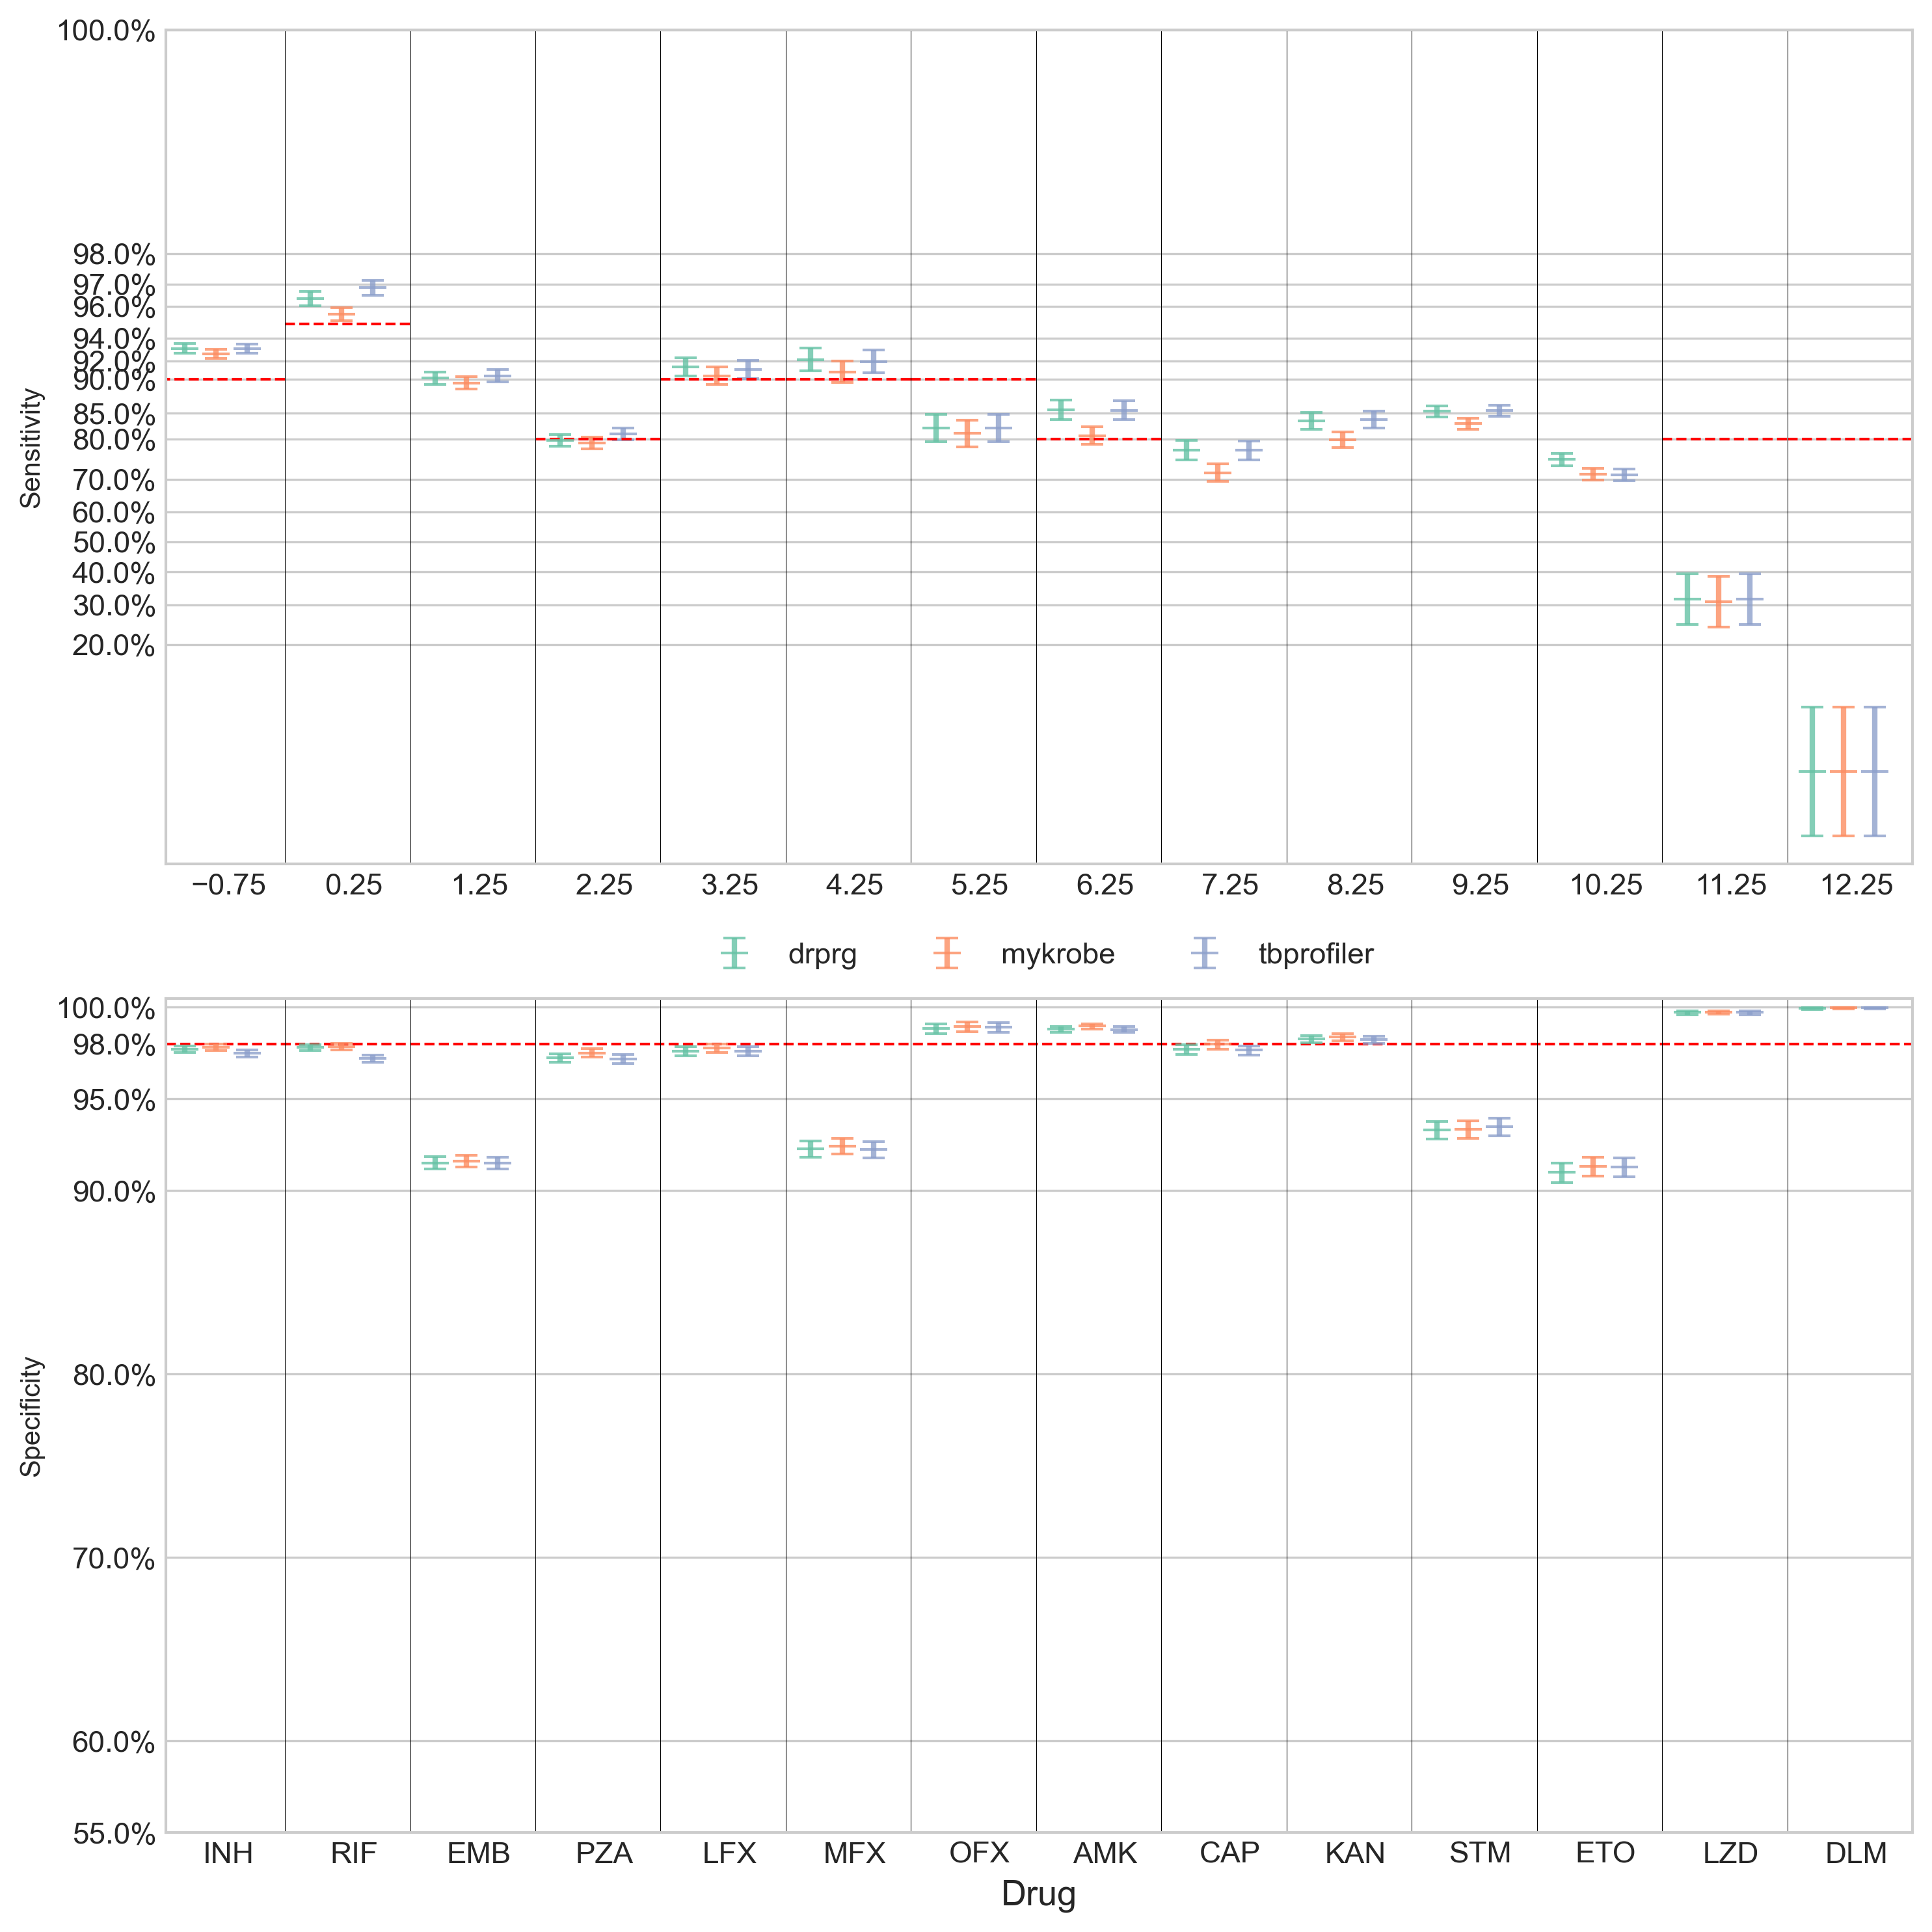

In [124]:
# PLOT SN
fig, axes = plt.subplots(figsize=(10, 10), dpi=DPI, nrows=2, tight_layout=True)
ax = axes.flatten()[0]

# plot details
bar_width = 0.2
epsilon = 0.05
fontsize = 11
rotate = 0
dodge = 0.1
capsize = 4
marker_alpha = 0.8
marker_size = 10
edge_alpha = 0.9
edgecol = to_rgba("black", alpha=edge_alpha)
edge_line_width = 2
sn_marker = "_"
sp_marker = "_"
legend_marker_size = 12

i = -1
all_positions = []
leghandles = []

for tool in tools:
    i += 1
    positions = [
        (p - 1) + ((bar_width + epsilon) * i) for p in np.arange(len(drugs))
    ]

    all_positions.append(positions)

    colour = to_rgba(CMAP[i], alpha=marker_alpha)
    label = tool


    plotprops = dict(
        label=label,
        color=colour,
        capsize=capsize,
        elinewidth=edge_line_width,
        mec=colour,
        markersize=marker_size,
        alpha=marker_alpha
    )


    tool_sn_df = sn_df.query("tool==@tool")
    sn_ys = tool_sn_df["value"]# * 100
    sn_lb = sn_ys - tool_sn_df["lower"]# * 100
#     sn_ub = tool_sn_df["upper"] * 100 - sn_ys
    sn_ub = tool_sn_df["upper"] - sn_ys

    sn_bar = ax.errorbar(
        x=[p - dodge for p in positions],
        y=sn_ys,
        yerr=[sn_lb, sn_ub],
        fmt=sn_marker,
        **plotprops,
    )

    h = mlines.Line2D(
        [],
        [],
        color=CMAP[i],
        marker=sn_marker,
        markersize=legend_marker_size,
        label=label,
    )
    leghandles.append(h)

labels = [long2short[d] for d in drug_order]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=rotate, fontsize=fontsize)

# make WHO target product profile for sensitivity bold - https://github.com/mbhall88/drprg/issues/22#issuecomment-1409639895
# page 14 in file:///Users/michaelhall/Downloads/9789240032361-eng.pdf
tpp_sn = {"RIF": 95, "INH": 90, "LFX": 90, "OFX": 90, "MFX": 90, "AMK": 80, "PZA": 80, "LZD": 80, "DLM": 80}

lines_y = []
lines_xmin = []
lines_xmax = []

for lab, pos in zip(labels, all_positions[-1]):
    target = tpp_sn.get(lab)
    pos += bar_width
    if target is None:
        continue

    lines_y.append(target/100)
    lines_xmin.append(pos-1)
    lines_xmax.append(pos)
ax.hlines(y=lines_y, xmin=lines_xmin, xmax=lines_xmax, colors=["red"], linestyles="dashed", linewidth=1)

ax.set_ylabel("Sensitivity")
ax.set_yscale("logit", nonpositive="clip")
# yticks = [x/100 for x in [1, 5, 10, 30, 40, 50, 60, 70, 80, 85, 90, 92, 94, 96, 97, 98]]
yticks = [x/100 for x in [20, 30, 40, 50, 60, 70, 80, 85, 90, 92, 94, 96, 97, 98, 99.9]]
ax.set_yticks(yticks)
ax.set_xticks(label_pos)
ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate, fontsize=fontsize)
ax.tick_params("both", labelsize=fontsize)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.minorticks_off()
yticklabels = [f"{x:.1f}%" for x in [20, 30, 40, 50, 60, 70, 80, 85, 90, 92, 94, 96, 97, 98, 100]]
ax.set_yticklabels(yticklabels)

legend_props = dict(
    loc="upper center",
    prop=dict(size=fontsize),
    frameon=False,
    ncol=len(tools) + 1,
)
# ax.legend(bbox_to_anchor=(0.5, 1.05), **legend_props)

ax.grid(
    False,
    axis="x",
)
# draw line between drug bars
for xpos in all_positions[-1]:
    vpos = xpos + bar_width
    ax.axvline(vpos, color="black", linestyle="-", linewidth=0.25)
    

xlim = (all_positions[0][0] - (epsilon + bar_width), vpos )
ax.set_xlim(xlim)

# _ = ax.set_xlabel("Drug", fontsize=fontsize + 2)


# PLOT SP
ax = axes.flatten()[1]

# plot details
# bar_width = 0.2
# epsilon = 0.05
# fontsize = 12
# rotate = 0
# dodge = 0.1
# capsize = 4
# marker_alpha = 0.8
# marker_size = 10
# edge_alpha = 0.9
# edgecol = to_rgba("black", alpha=edge_alpha)
# edge_line_width = 2
# sn_marker = "_"
# sp_marker = "_"
# legend_marker_size = 12

i = -1
all_positions = []
leghandles = []

for tool in tools:
    i += 1
    positions = [
        (p - 1) + ((bar_width + epsilon) * i) for p in np.arange(len(drugs))
    ]

    all_positions.append(positions)

    colour = to_rgba(CMAP[i], alpha=marker_alpha)
    label = tool


    plotprops = dict(
        label=label,
        color=colour,
        capsize=capsize,
        elinewidth=edge_line_width,
        mec=colour,
        markersize=marker_size,
        alpha=marker_alpha
    )


    tool_sp_df = sp_df.query("tool==@tool")
    sp_ys = tool_sp_df["value"]# * 100
    sp_lb = sp_ys - tool_sp_df["lower"]# * 100
#     sn_ub = tool_sn_df["upper"] * 100 - sn_ys
    sp_ub = tool_sp_df["upper"] - sp_ys

    sp_bar = ax.errorbar(
        x=[p - dodge for p in positions],
        y=sp_ys,
        yerr=[sp_lb, sp_ub],
        fmt=sp_marker,
        **plotprops,
    )

    h = mlines.Line2D(
        [],
        [],
        color=CMAP[i],
        marker=sp_marker,
        markersize=legend_marker_size,
        label=label,
    )
    leghandles.append(h)

labels = [long2short[d] for d in drug_order]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=rotate, fontsize=fontsize)
ax.set_ylabel("Specificity")
# ax.set_yscale("logit")
# yticks = [x/100 for x in [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]]
yticks = [x/100 for x in [55, 60, 70, 80, 90, 95, 98, 100]]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xticks(label_pos)
ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate, fontsize=fontsize)
ax.tick_params("both", labelsize=fontsize)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
# ax.minorticks_off()

legend_props = dict(
    loc="upper center",
    prop=dict(size=fontsize),
    frameon=False,
    ncol=len(tools) + 1,
)
ax.legend(bbox_to_anchor=(0.5, 1.1), **legend_props)

ax.grid(
    False,
    axis="x",
)
# draw line between drug bars
for xpos in all_positions[-1]:
    vpos = xpos + bar_width
    ax.axvline(vpos, color="black", linestyle="-", linewidth=0.25)
    
# make WHO target product profile for specificity bold - https://github.com/mbhall88/drprg/issues/22#issuecomment-1409639895
target = 98
lines = ax.get_ygridlines()
who_line = lines[yticks.index(target/100)]
who_line.set_color("red")
who_line.set_linestyle("--")
who_line.set_linewidth(1)

xlim = (all_positions[0][0] - (epsilon + bar_width), vpos )
ax.set_xlim(xlim)

_ = ax.set_xlabel("Drug", fontsize=fontsize + 2)
# plt.tight_layout()

In [227]:
fig.savefig(f"../../docs/paper/figures/sn_sp.{TECH}.png")

## Phenotype availability

In [165]:
pheno_df = pd.read_csv("../../config/illumina.samplesheet.csv", low_memory=False)
len(pheno_df)

45702

In [166]:
qc = pd.read_csv("../../results/QC/illumina.qc.csv", index_col="run")
min_depth = 15
max_contam = 0.05
valid_samples = qc.query("coverage>=@min_depth and f_contam<=@max_contam").index

In [167]:
pheno_df.query("run in @valid_samples", inplace=True)
len(pheno_df)

44709

In [168]:
pheno_df.set_index("run", inplace=True)
pheno_df.rename(columns={"para-aminosalicylic_acid": "PAS"}, inplace=True)
drop_cols = {"biosample", "bioproject"}
pheno_df = pheno_df.drop(columns=drop_cols).melt(ignore_index=False, var_name="drug", value_name="phenotype").reset_index()

In [169]:
print(len(pheno_df))
# pheno_df.query("drug in @drugs", inplace=True)
print(len(pheno_df))

983598
983598


In [170]:
pheno_df

,run,drug,phenotype
0,ERR036186,amikacin,NaN
1,ERR036187,amikacin,NaN
2,ERR036188,amikacin,NaN
3,ERR036189,amikacin,NaN
4,ERR036190,amikacin,NaN
...,...,...,...
983593,SRR8651577,thioacetazone,NaN
983594,SRR8651583,thioacetazone,NaN
983595,SRR8651589,thioacetazone,NaN
983596,SRR8651594,thioacetazone,NaN


In [171]:
ont_pheno_df = pd.read_csv("../../config/nanopore.samplesheet.csv", low_memory=False)
len(ont_pheno_df)

142

In [172]:
ont_qc = pd.read_csv("../../results/QC/nanopore.qc.csv", index_col="run")
ont_valid_samples = ont_qc.query("coverage>=@min_depth and f_contam<=@max_contam").index

In [173]:
ont_pheno_df.query("run in @ont_valid_samples", inplace=True)
len(ont_pheno_df)

138

In [174]:
ont_pheno_df.set_index("run", inplace=True)
ont_pheno_df.rename(columns={"para-aminosalicylic_acid": "PAS"}, inplace=True)
ont_pheno_df = ont_pheno_df.drop(columns=drop_cols).melt(ignore_index=False, var_name="drug", value_name="phenotype").reset_index()

In [175]:
print(len(ont_pheno_df))
# ont_pheno_df.query("drug in @drugs", inplace=True)
print(len(ont_pheno_df))


2484
2484


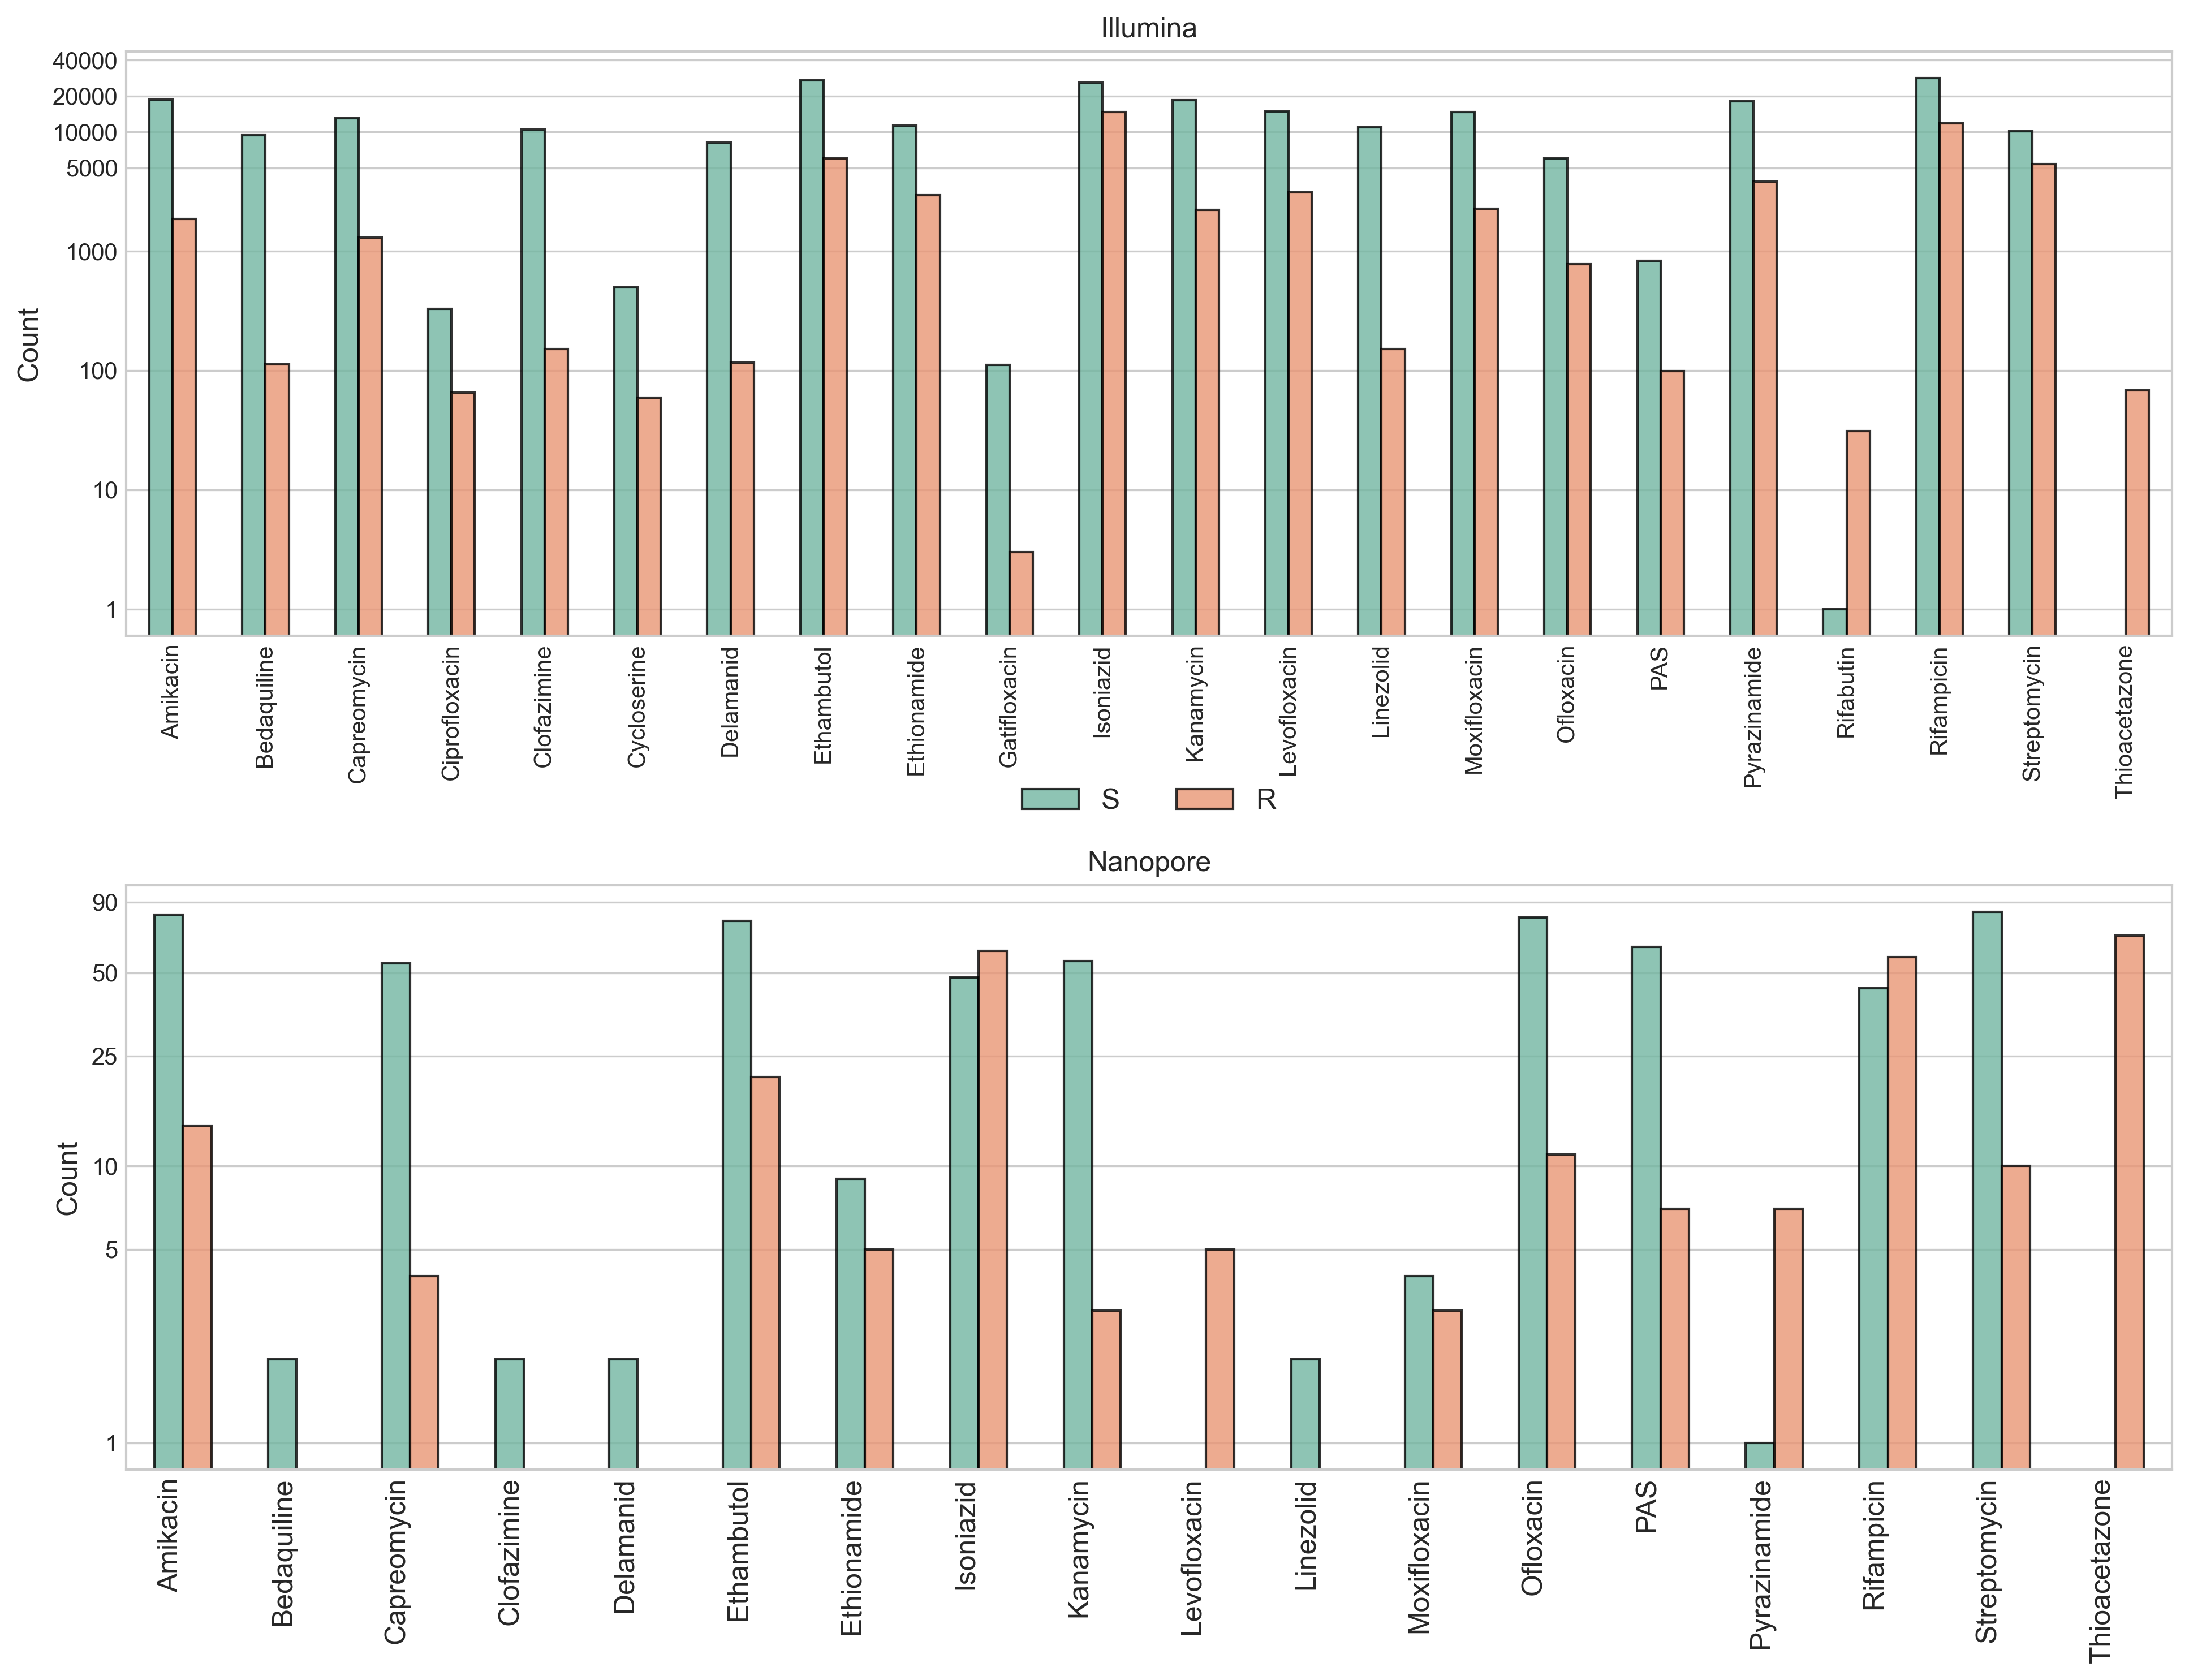

In [193]:
fig, axes = plt.subplots(nrows=2, dpi=300, figsize=(13, 10), sharex=False)
fontsize = 12
rotation = 90
ax = axes.flatten()[0]
data = pheno_df.dropna().sort_values(by="drug")
ax.set_title("Illumina")
counts = data.groupby(["drug", "phenotype"]).count().reset_index()
drugs = [s.capitalize() if not s.isupper() else s for s in counts["drug"]]
counts["drug"] = drugs
sns.barplot(
    data=counts, 
    x="drug", 
    y="run", 
    hue="phenotype", 
    ax=ax, 
    palette=CMAP, 
    hue_order=["S", "R"], 
    order=sorted(set(drugs)),
    linewidth=1, 
    edgecolor="black", 
    alpha=0.8, 
    width=0.5
)
yticks = [1, 10, 100, 1000, 5000, 10000, 20000, 40000]
ax.set_yscale("log")
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_ylabel("Count", fontsize=fontsize)
ax.set_xlabel("")
legend_props = dict(
    loc="lower center",
    prop=dict(size=fontsize),
    frameon=False,
    ncol=2,
)
ax.legend(bbox_to_anchor=(0.5, -0.35), **legend_props)
# _ = ax.set_xticks(ax.get_xticks(), rotation=80)
ax.tick_params(labelrotation=rotation, axis="x")

ax = axes.flatten()[1]
data = ont_pheno_df.dropna()
ax.set_title("Nanopore")
counts = data.groupby(["drug", "phenotype"]).count().reset_index()
drugs = [s.capitalize() if not s.isupper() else s for s in counts["drug"]]
counts["drug"] = drugs
sns.barplot(
    data=counts, 
    x="drug", 
    y="run", 
    hue="phenotype", 
    ax=ax, 
    palette=CMAP, 
    hue_order=["S", "R"], 
    order=sorted(set(drugs)),
    linewidth=1, 
    edgecolor="black", 
    alpha=0.8, 
    width=0.5
)
yticks = [1, 5, 10, 25, 50, 90]
ax.set_yscale("log")
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_ylabel("Count", fontsize=fontsize)
ax.set_xlabel("")
plt.xticks(rotation=rotation, ha='right', fontsize=fontsize)
ax.get_legend().remove()
plt.tight_layout()

In [195]:
fig.savefig("../../docs/paper/figures/pheno_avail.png")

## Plot lineage

In [30]:
from collections import Counter
import re
from typing import List

In [31]:
LINEAGE_DELIM = "."
LINEAGE_REGEX = re.compile(
    rf"^(?P<notation>lineage|La)(?P<markers>[-\w]+(\{LINEAGE_DELIM}[-\w]+)*)$"
)
class InvalidLineageString(Exception):
    pass

class Lineage:
    """A class representing a lineage and any of its sublineage information."""

    def __init__(
        self,
        markers: List[str],
        notation: str,
        delim: str = ".",
    ):
        self.markers = markers
        self.notation = notation
        self._delim = delim

    def __str__(self):
        return f"{self.notation}{self._delim.join(self.markers)}"

    @staticmethod
    def from_str(s: str) -> "Lineage":
        """Create a Lineage object from a str."""
        match = LINEAGE_REGEX.search(s)
        if not match:
            raise InvalidLineageString(
                f"Lineage string {s} is not in the expected format."
            )
        notation = match.group("notation")
        markers = match.group("markers")
        
        return Lineage(notation=notation, markers=markers.split(LINEAGE_DELIM))

    def __eq__(self, other: "Lineage") -> bool:
        return self.notation == other.notation and self.markers == other.markers

    def __lt__(self, other: "Lineage") -> bool:
        return len(self.markers) < len(other.markers)

    def mrca(self, other: "Lineage") -> Optional["Lineage"]:
        """Determine the most recent common ancestor between two Lineages.
        Returns None if there is no MRCA.
        """
        if other is None or self.notation != other.notation:
            return None
        
        mrca = []
        for l1, l2 in zip(self.markers, other.markers):
            if l1 == l2:
                mrca.append(l1)
            else:
                break
                
        if not mrca:
            return None
        

        return Lineage(notation=self.notation, markers=mrca)

    @staticmethod
    def call(lineages: List["Lineage"]) -> Optional["Lineage"]:
        """Returns the Lineage with the most specific minor.
        if the majors are different, returns None. If minors are the same, then takes
        MRCA of the lineages with the same minor length.
        """
        if not lineages:
            return None
        if len(lineages) == 1:
            return lineages[0]
        lineages.sort()
        lineage = lineages[0]
        for lin in lineages:
            lineage = lin.mrca(lineage)

        return lineage



In [284]:
lindf = pd.read_csv("../../results/amr_predictions/tbprofiler/illumina/summary.csv").loc[:,["run", "lineage"]]

In [285]:
d = {}
for _, row in lindf.iterrows():
    r = row["run"]
    l = row["lineage"]
    if r in d:
        assert d[r] == l or d[r] is l, r
    else:
        d[r] = l

In [286]:
lindf = pd.DataFrame(list(d.items()), columns=["run", "lineage"]).set_index("run", verify_integrity=True)
lindf = lindf.loc[lindf.index.isin(valid_samples)]
len(lindf)

44213

In [287]:
l = len(lindf)
lindf = lindf.loc[~lindf["lineage"].isna()]
print(f"Lost {l - len(lindf)} runs due to NaN to give a total of {len(lindf)}")
l = len(lindf)

Lost 17 runs due to NaN to give a total of 44196


In [288]:
lineages = []
for l in lindf["lineage"]:
    lins = [Lineage.from_str(x.strip()) for x in l.split(";")]
    call = Lineage.call(lins)
    if call is not None:
        call = str(call)
    lineages.append(call)

In [289]:
lindf["lineage"] = lineages

In [290]:
l = len(lindf)
lindf = lindf.loc[~lindf["lineage"].isnull()]
print(f"Lost {l - len(lindf)} runs to multiple lineage assignments to give a total of {len(lindf)}")
l = len(lindf)

Lost 423 runs to multiple lineage assignments to give a total of 43773


In [291]:
def parent(s: str) -> str:
    if LINEAGE_DELIM not in s:
        return s
    else:
        return s.rsplit(LINEAGE_DELIM, maxsplit=1)[0]
    
def generate_path(s):
    prev_par = s.replace("-", "_")
    path = [prev_par]
    par = parent(prev_par).replace("-", "_")
    same = par == prev_par
    prev_par = par

    while not same:
        path.insert(0, prev_par)
        par = parent(prev_par).replace("-", "_")
        same = prev_par == par
        prev_par = par
        
        
#     path.insert(0, par)
    path.append("end")
    return "-".join(path).replace("-lineage", "-").replace("-La", "-")

In [292]:
icicle_data = Counter()
n = 2
path_data = []
for lineage, count in Counter(lindf["lineage"]).items():
    par = lineage.split(".")[0]
    groups = lineage.split(".")
    lin = '.'.join(groups[:n])
    icicle_data[par] += count
    path_data.append((generate_path(lineage), count))

In [293]:
def build_hierarchy(csv):
    # Helper function that transforms the given CSV into a hierarchical format.
    root = {"name": "root", "children": []}
    for row in csv:
        sequence = row[0]
        size = int(row[1])
        if isinstance(size, str):
            # e.g. if this is a header row
            continue
        parts = sequence.split("-")
        current_node = root
        for j in range(len(parts)):
            children = current_node["children"]
            node_name = parts[j]
            child_node = None
            if j + 1 < len(parts):
                # Not yet at the end of the sequence; move down the tree.
                found_child = False
                for child in children:
                    if child["name"] == node_name:
                        child_node = child
                        found_child = True
                        break
                # If we don't already have a child node for this branch, create it.
                if not found_child:
                    child_node = {"name": node_name, "children": []}
                    children.append(child_node)
                current_node = child_node
            else:
                current_node["size"] = size
                # Reached the end of the sequence; create a leaf node.
#                 child_node = {"name": node_name, "size": size}
#                 children.append(child_node)
                           
    return root

In [294]:
hierachy = build_hierarchy(path_data)

In [295]:
data = []
for par, count in icicle_data.items():
    data.append((par, count))

In [296]:
icicle_df = pd.DataFrame(data, columns=["parent", "count"])
icicle_df.sort_values(by="parent", inplace=True)

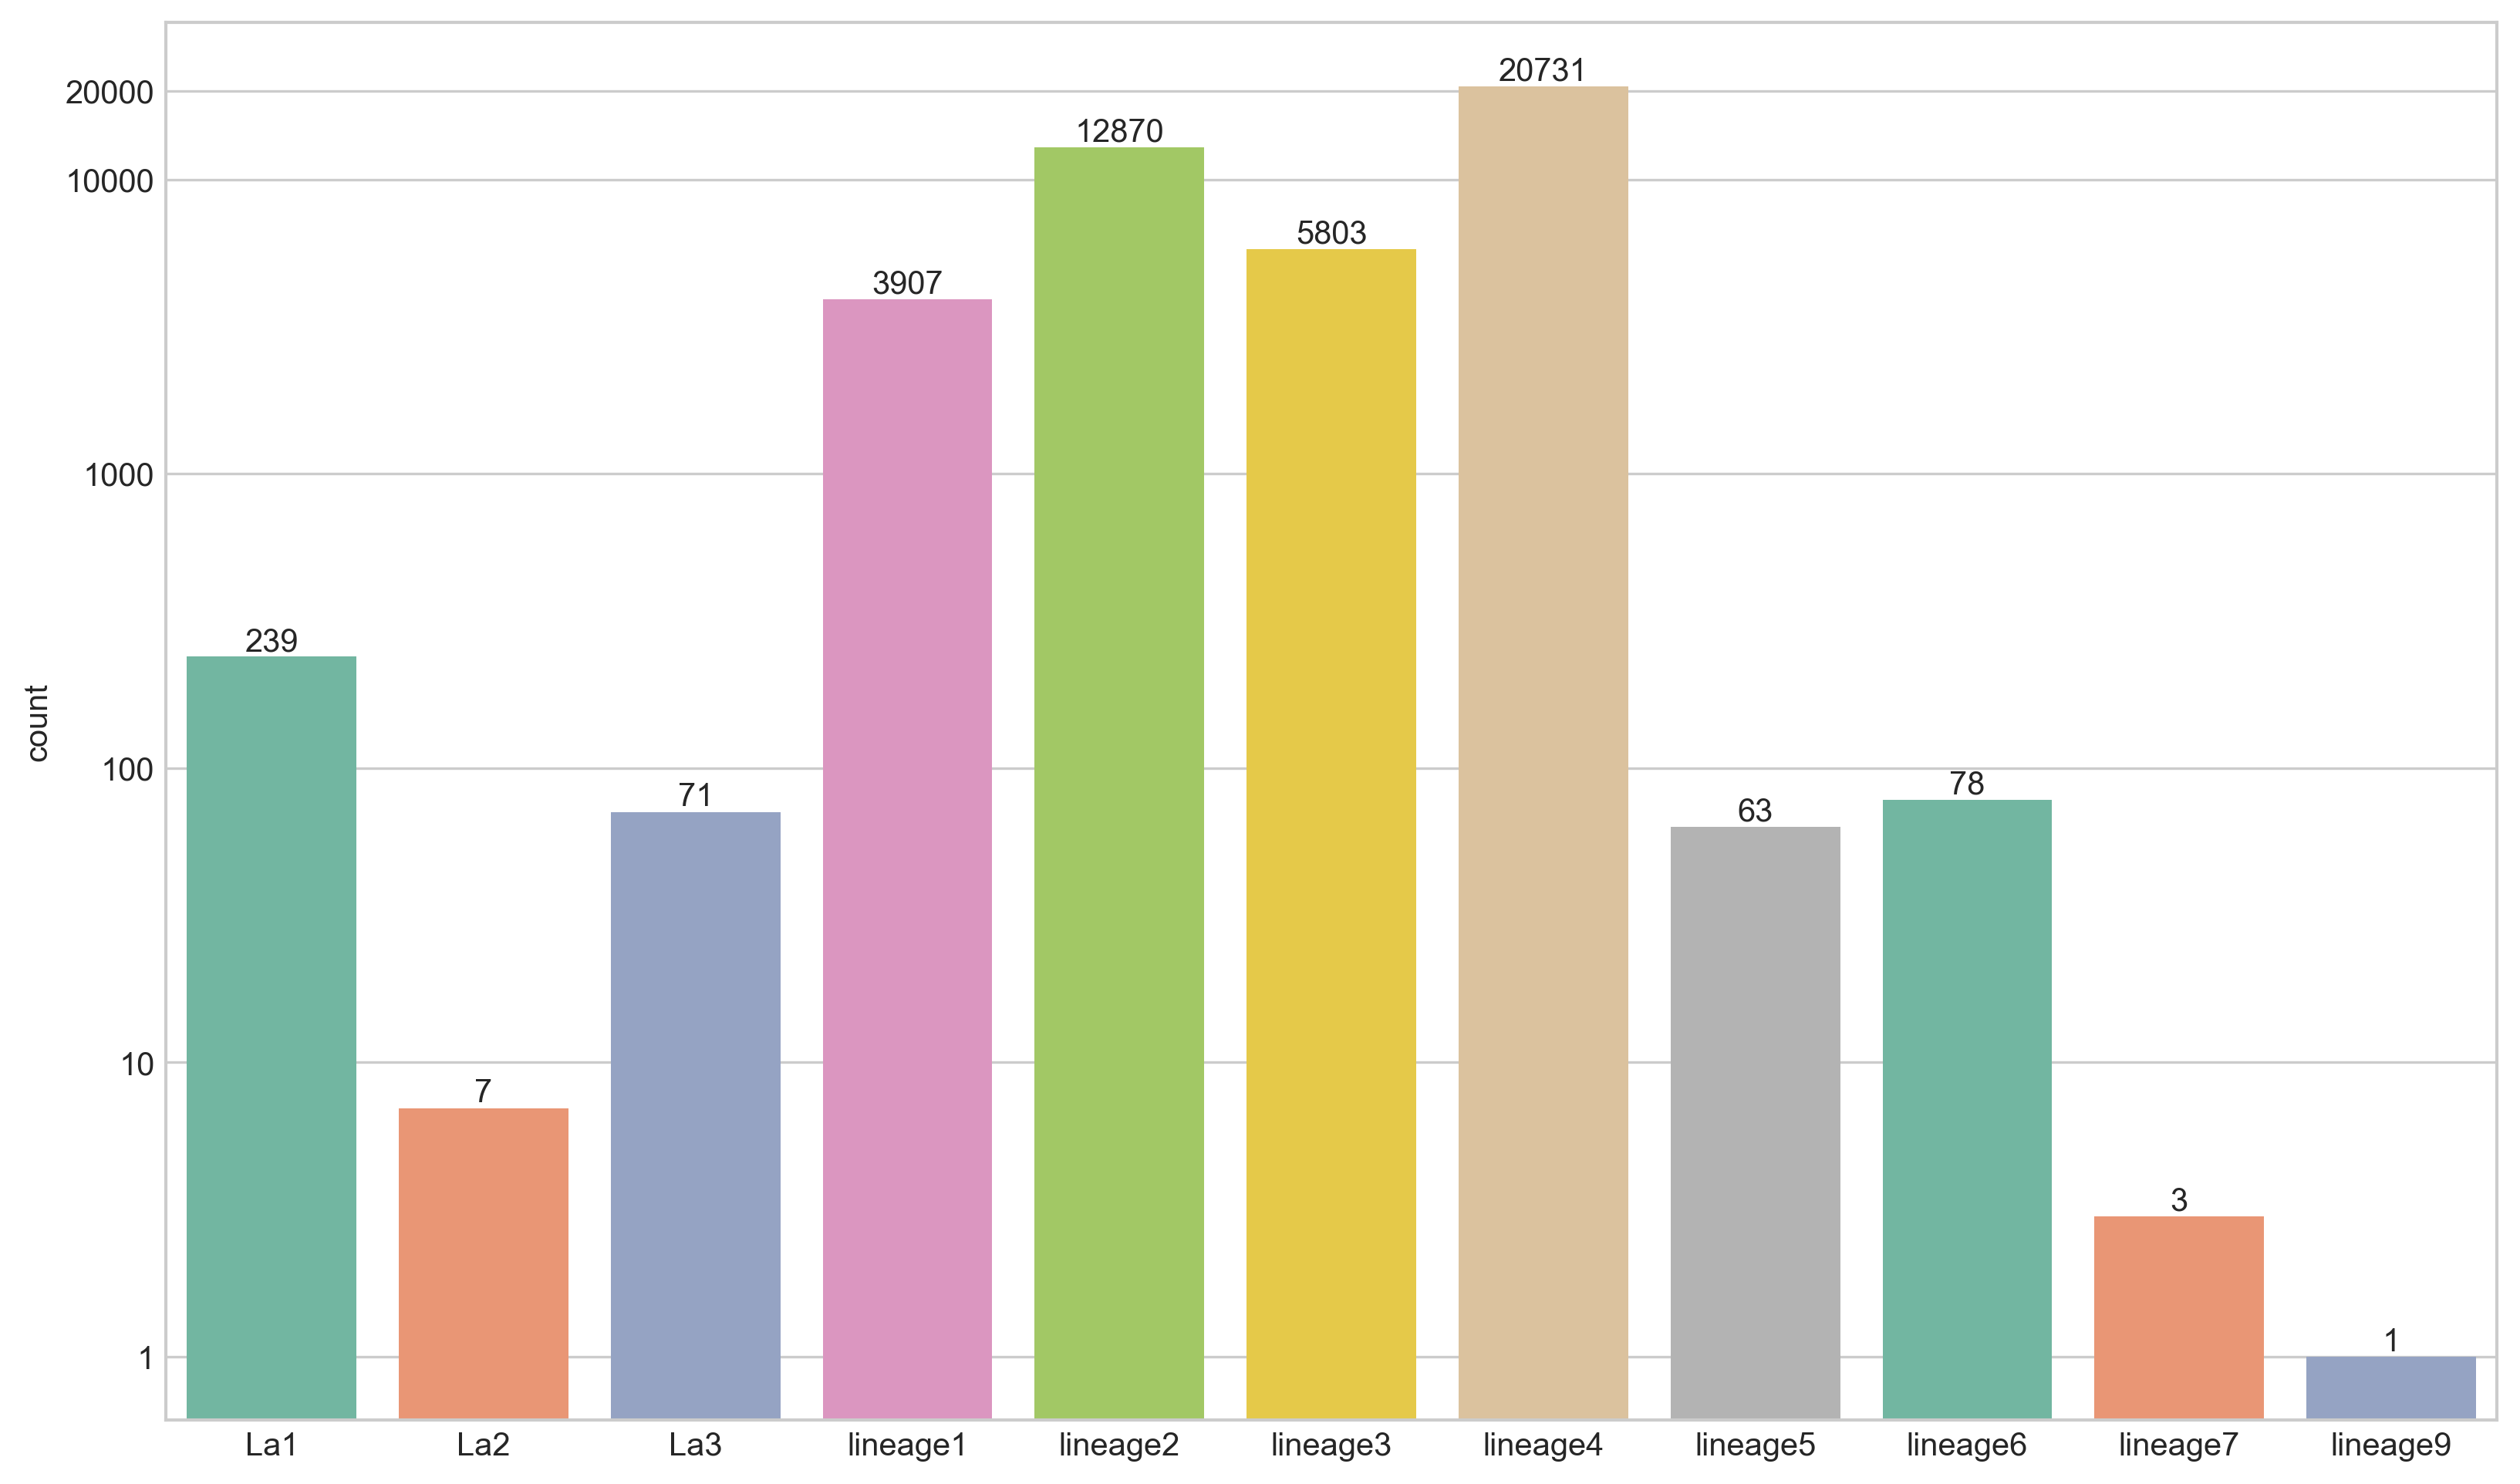

In [232]:
fig, ax = plt.subplots(dpi=DPI, figsize=FIGSIZE)
sns.barplot(icicle_df, x="parent", y="count", palette=CMAP)
ax.set_yscale("log")
yticks = [1, 10, 100, 1_000, 10_000, 20_000]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel("")
for bars in ax.containers:
    ax.bar_label(bars)

In [233]:
fig.savefig("../../docs/paper/figures/lineages.png")

In [297]:
icicle_df.rename(columns={"count": "illumina_count"}, inplace=True)

In [298]:
ont_qc = pd.read_csv("../../results/QC/nanopore.qc.csv", index_col="run")

In [299]:
ont_valid_samples = ont_qc.query("coverage>=@min_depth and f_contam<=@max_contam").index

In [300]:
ont_lindf = pd.read_csv("../../results/amr_predictions/tbprofiler/nanopore/summary.csv").loc[:,["run", "lineage"]]

In [301]:
ont_d = {}
for _, row in ont_lindf.iterrows():
    r = row["run"]
    l = row["lineage"]
    if r in d:
        assert ont_d[r] == l or ont_d[r] is l, r
    else:
        ont_d[r] = l

In [302]:
ont_lindf = pd.DataFrame(list(ont_d.items()), columns=["run", "lineage"]).set_index("run", verify_integrity=True)
ont_lindf = ont_lindf.loc[ont_lindf.index.isin(ont_valid_samples)]
len(ont_lindf)

138

In [303]:
l = len(ont_lindf)
ont_lindf = ont_lindf.loc[~ont_lindf["lineage"].isna()]
print(f"Lost {l - len(ont_lindf)} runs due to NaN to give a total of {len(ont_lindf)}")
l = len(ont_lindf)

Lost 0 runs due to NaN to give a total of 138


In [304]:
ont_lineages = []
for l in ont_lindf["lineage"]:
    lins = [Lineage.from_str(x.strip()) for x in l.split(";")]
    call = Lineage.call(lins)
    if call is not None:
        call = str(call)
    ont_lineages.append(call)

In [305]:
ont_lindf["lineage"] = ont_lineages

In [306]:
l = len(ont_lindf)
ont_lindf = ont_lindf.loc[~ont_lindf["lineage"].isnull()]
print(f"Lost {l - len(ont_lindf)} runs to multiple lineage assignments to give a total of {len(ont_lindf)}")
l = len(ont_lindf)

Lost 0 runs to multiple lineage assignments to give a total of 138


In [307]:
ont_icicle_data = Counter()
n = 2
path_data = []
for lineage, count in Counter(ont_lindf["lineage"]).items():
    par = lineage.split(".")[0]
    groups = lineage.split(".")
    lin = '.'.join(groups[:n])
    ont_icicle_data[par] += count

In [308]:
ont_data = []
for par, count in ont_icicle_data.items():
    ont_data.append((par, int(count)))

In [309]:
ont_icicle_df = pd.DataFrame(ont_data, columns=["parent", "count"])
ont_icicle_df.sort_values(by="parent", inplace=True)

In [310]:
ont_icicle_df.rename(columns={"count": "nanopore_count"}, inplace=True)

In [311]:
icicle_df = icicle_df.set_index("parent").join(ont_icicle_df.set_index("parent")).fillna(0)

In [313]:
icicle_df["nanopore_count"] = icicle_df["nanopore_count"].astype(int)
icicle_df

,illumina_count,nanopore_count
parent,,
La1,239,0
La2,7,0
La3,71,0
lineage1,3907,32
lineage2,12870,38
lineage3,5803,9
lineage4,20731,59
lineage5,63,0
lineage6,78,0


In [314]:
icicle_df.to_csv("../../docs/paper/tables/lineage.csv")

# Plot benchmark

## Illumina

In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import to_rgba
from statannotations.Annotator import Annotator

PALETTE = "Set2"
FS = 12
STATS_TEST = "Wilcoxon"

In [114]:
def legend_without_duplicate_labels(ax, title=""):
    handles, labels = ax.get_legend_handles_labels()
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    ax.legend(*zip(*unique), title=title, fontsize=FS)

In [115]:
qc = pd.read_csv(f"../../results/QC/illumina.qc.csv", index_col="run")
valid_samples = qc.query("coverage>=@min_depth and f_contam<=@max_contam").index

In [116]:
df = pd.read_csv("../../results/benchmark/predict/illumina.summary.csv")
df.query("run in @valid_samples", inplace=True)

In [117]:
ont_qc = pd.read_csv(f"../../results/QC/nanopore.qc.csv", index_col="run")
ont_valid_samples = ont_qc.query("coverage>=@min_depth and f_contam<=@max_contam").index

In [118]:
ont_df = pd.read_csv("../../results/benchmark/predict/nanopore.summary.csv")
ont_df.query("run in @ont_valid_samples", inplace=True)

p-value annotation legend:
      ns: p <= 1.00e+00
$p\leq0.05$: 1.00e-02 < p <= 5.00e-02
$p\leq0.01$: 1.00e-03 < p <= 1.00e-02
$p\leq0.001$: 1.00e-04 < p <= 1.00e-03
$p\leq0.0001$: p <= 1.00e-04

drprg vs. mykrobe: Wilcoxon test (paired samples), P_val:0.000e+00 Stat=5.265e+06
mykrobe vs. tbprofiler: Wilcoxon test (paired samples), P_val:4.857e-120 Stat=4.362e+08
drprg vs. tbprofiler: Wilcoxon test (paired samples), P_val:0.000e+00 Stat=2.917e+07
p-value annotation legend:
      ns: p <= 1.00e+00
$p\leq0.05$: 1.00e-02 < p <= 5.00e-02
$p\leq0.01$: 1.00e-03 < p <= 1.00e-02
$p\leq0.001$: 1.00e-04 < p <= 1.00e-03
$p\leq0.0001$: p <= 1.00e-04

drprg vs. mykrobe: Wilcoxon test (paired samples), P_val:1.029e-23 Stat=7.200e+01
mykrobe vs. tbprofiler: Wilcoxon test (paired samples), P_val:2.344e-07 Stat=2.363e+03
drprg vs. tbprofiler: Wilcoxon test (paired samples), P_val:2.096e-22 Stat=2.140e+02
p-value annotation legend:
      ns: p <= 1.00e+00
$p\leq0.05$: 1.00e-02 < p <= 5.00e-02
$p\leq0.01

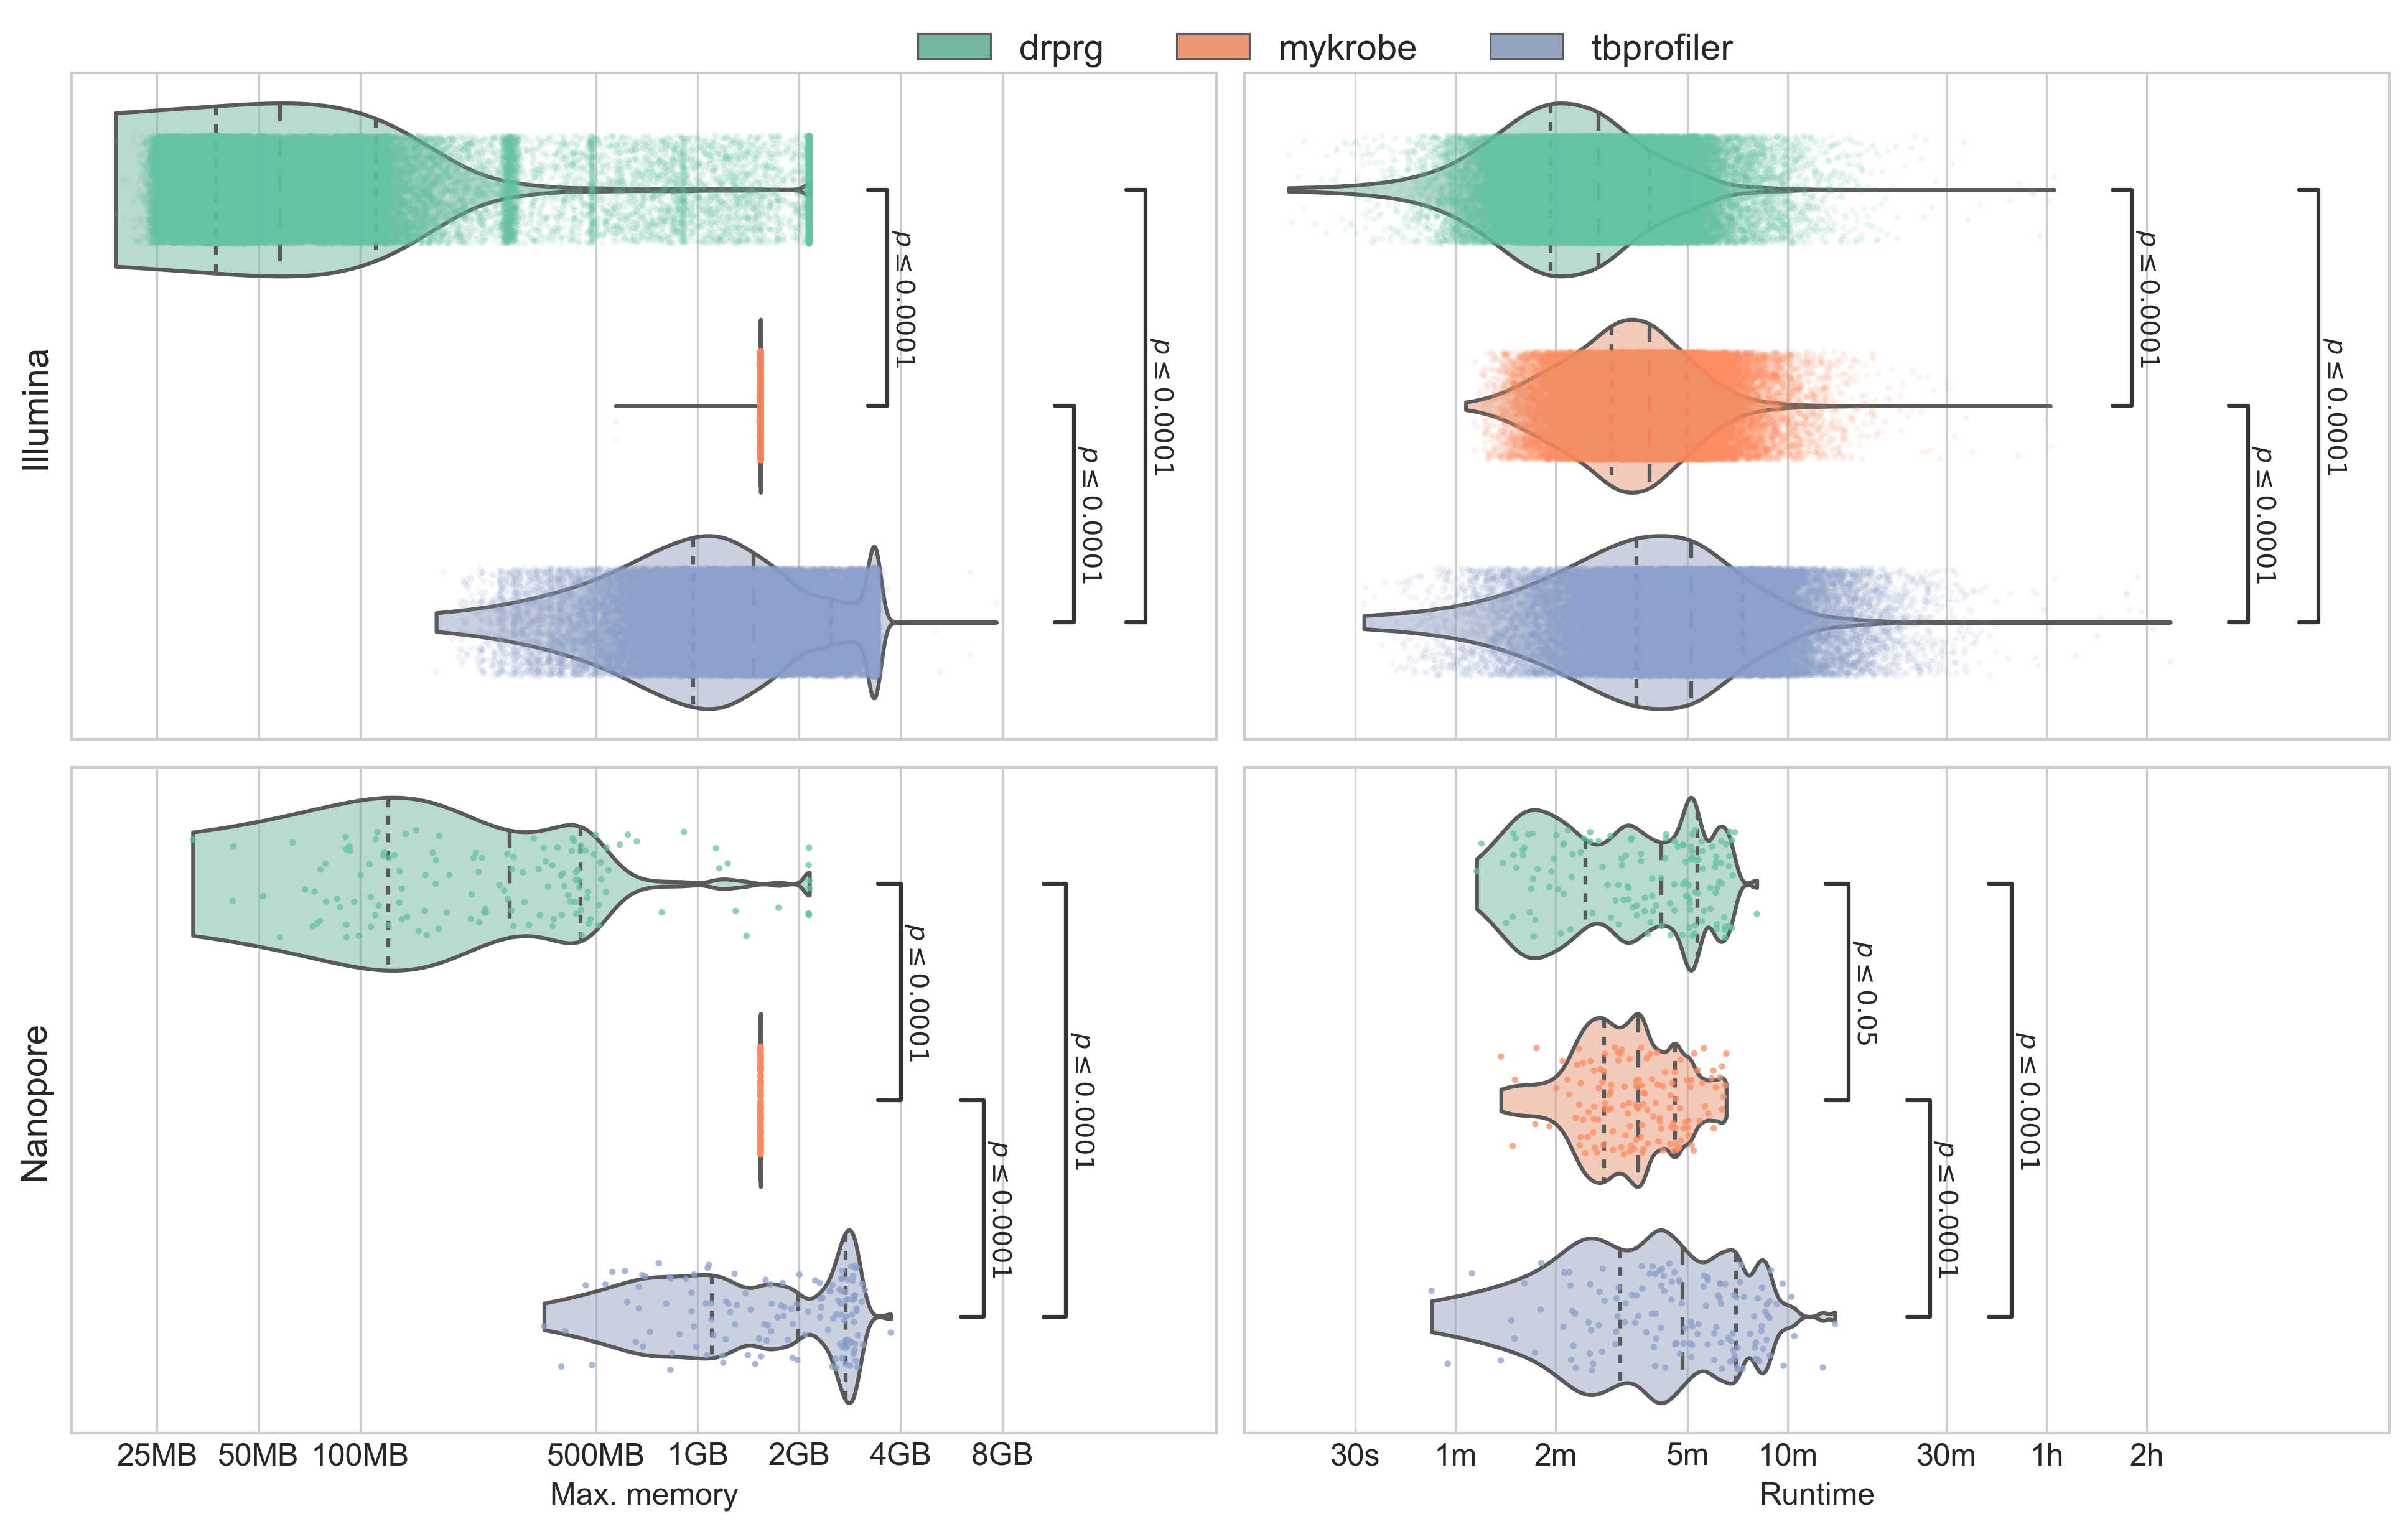

In [119]:
# PLOT MEMORY
fig, axes = plt.subplots(figsize=(13, 8), dpi=300, tight_layout=True, nrows=2, ncols=2, sharey=True)

axes[0][0].sharex(axes[1][0])
axes[0][1].sharex(axes[1][1])

mem_ax = axes[0][0]

y = "tool"
hue = "tool"
x = "max_rss"
hue_order = sorted(set(df["tool"]))
pval_fmt = {
    "pvalue_thresholds": [
        [1e-4, "$p\leq0.0001$"],
        [1e-3, "$p\leq0.001$"],
        [1e-2, "$p\leq0.01$"],
        [0.05, "$p\leq0.05$"],
        [1, "ns"],
    ]
}
violin_alpha = 0.5
ill_strip_alpha = 0.1
orient = "h"
bw = 0.15
jitter = 0.25
lw = 0.5
gridsize = 1000
psize = 2.5

kwargs = dict(
    x=x,
    y=y,
    hue=hue,
    palette=PALETTE,
    hue_order=hue_order,
    order=hue_order,
    orient=orient,
    dodge=False,
)

sns.violinplot(**kwargs, cut=0, inner="quartile", ax=mem_ax, gridsize=gridsize, bw=bw, data=df)
for violin in mem_ax.collections:
    violin.set_facecolor(to_rgba(violin.get_facecolor(), alpha=violin_alpha))

sns.stripplot(
    **kwargs, 
    alpha=ill_strip_alpha, 
    edgecolor=None, 
    linewidth=lw, 
    ax=mem_ax, 
    jitter=jitter, 
    size=psize, 
    data=df
)

mem_ax.set_xscale("log")
ticks = [
    (25, "25MB"),
    (50, "50MB"),
    (100, "100MB"),
    (500, "500MB"),
    (1000, "1GB"),
    (2000, "2GB"),
#     (3000, "3GB"),
    (4000, "4GB"),
    (8000, "8GB")
]
mem_ax.set_xticks([t[0] for t in ticks])
mem_ax.set_xticklabels([])
mem_ax.set_xlabel("")
mem_ax.set_ylabel("Illumina", fontsize=FS+2)
mem_ax.tick_params(axis="both", which="major", labelsize=FS)
mem_ax.set_yticklabels([])

pairs = [("drprg", "mykrobe"), ("mykrobe", "tbprofiler"), ("drprg", "tbprofiler")]

legend_without_duplicate_labels(mem_ax)

annot = Annotator(mem_ax, pairs, data=df, x=x, y=y, orient=orient, order=hue_order)
annot.configure(test=STATS_TEST, pvalue_format=pval_fmt)
annot.apply_test()
annot.annotate()

# PLOT ONT MEM
mem_ax = axes[1][0]

ont_strip_alpha = 0.75

sns.violinplot(data=ont_df, **kwargs, cut=0, inner="quartile", ax=mem_ax, gridsize=gridsize, bw=bw)
for violin in mem_ax.collections:
    violin.set_facecolor(to_rgba(violin.get_facecolor(), alpha=violin_alpha))

sns.stripplot(
    data=ont_df, 
    **kwargs, 
    alpha=ont_strip_alpha, 
    edgecolor=None, 
    linewidth=lw, 
    ax=mem_ax, 
    jitter=jitter, 
    size=psize
)

mem_ax.set_xscale("log")
ticks = [
    (25, "25MB"),
    (50, "50MB"),
    (100, "100MB"),
    (500, "500MB"),
    (1000, "1GB"),
    (2000, "2GB"),
#     (3000, "3GB"),
    (4000, "4GB"),
    (8000, "8GB")
]
mem_ax.set_xticks([t[0] for t in ticks])
mem_ax.set_xticklabels([t[1] for t in ticks], fontsize=FS)
mem_ax.set_xlabel("Max. memory", fontsize=FS)
mem_ax.set_ylabel("Nanopore", fontsize=FS+2)
mem_ax.tick_params(axis="both", which="major", labelsize=FS)
mem_ax.set_yticklabels([])

pairs = [("drprg", "mykrobe"), ("mykrobe", "tbprofiler"), ("drprg", "tbprofiler")]

legend_without_duplicate_labels(mem_ax)

annot = Annotator(mem_ax, pairs, data=ont_df, x=x, y=y, orient=orient, order=hue_order)
annot.configure(test=STATS_TEST, pvalue_format=pval_fmt)
annot.apply_test()
annot.annotate()

# PLOT ILLUMINA RUNTIME
rt_ax = axes[0][1]

x = "s"
kwargs["x"] = x

sns.violinplot(data=df, **kwargs, cut=0, inner="quartile", ax=rt_ax, gridsize=gridsize, bw=bw)
for violin in rt_ax.collections:
    violin.set_facecolor(to_rgba(violin.get_facecolor(), alpha=violin_alpha))

sns.stripplot(
    data=df, 
    **kwargs, 
    alpha=ill_strip_alpha, 
    edgecolor=None, 
    linewidth=lw, 
    ax=rt_ax, 
    jitter=jitter, 
    size=psize
)

rt_ax.set_xscale("log")
ticks = [
    (30, "30s"),
    (60, "1m"),
    (120, "2m"),
#     (180, "3m"),
    (300, "5m"),
    (600, "10m"),
    (1800, "30m"),
    (3600, "1h"),
    (7200, "2h")
]
rt_ax.set_xticks([t[0] for t in ticks])
rt_ax.set_xticklabels([])#[t[1] for t in ticks], fontsize=FS)
rt_ax.set_xlabel("")
rt_ax.set_ylabel("")
rt_ax.tick_params(axis="both", which="major", labelsize=FS)
rt_ax.set_yticklabels([])

legend_without_duplicate_labels(rt_ax)

annot.reset_configuration()
annot = Annotator(rt_ax, pairs, data=df, x=x, y=y, orient=orient, order=hue_order)
annot.configure(test=STATS_TEST, pvalue_format=pval_fmt)
annot.apply_test()
annot.annotate()

# PLOT ONT RUNTIME
rt_ax = axes[1][1]

sns.violinplot(data=ont_df, **kwargs, cut=0, inner="quartile", ax=rt_ax, gridsize=gridsize, bw=bw)
for violin in rt_ax.collections:
    violin.set_facecolor(to_rgba(violin.get_facecolor(), alpha=violin_alpha))

sns.stripplot(
    data=ont_df, 
    **kwargs, 
    alpha=ont_strip_alpha, 
    edgecolor=None, 
    linewidth=lw, 
    ax=rt_ax, 
    jitter=jitter, 
    size=psize
)

rt_ax.set_xscale("log")
ticks = [
    (30, "30s"),
    (60, "1m"),
    (120, "2m"),
#     (180, "3m"),
    (300, "5m"),
    (600, "10m"),
    (1800, "30m"),
    (3600, "1h"),
    (7200, "2h")
]
rt_ax.set_xticks([t[0] for t in ticks])
rt_ax.set_xticklabels([t[1] for t in ticks], fontsize=FS)
rt_ax.set_xlabel("Runtime", fontsize=FS)
rt_ax.set_ylabel("")
rt_ax.tick_params(axis="both", which="major", labelsize=FS)
rt_ax.set_yticklabels([])

rt_ax.xaxis.set_tick_params(labelbottom=True, labeltop=False)

legend_without_duplicate_labels(rt_ax)

annot.reset_configuration()
annot = Annotator(rt_ax, pairs, data=ont_df, x=x, y=y, orient=orient, order=hue_order)
annot.configure(test=STATS_TEST, pvalue_format=pval_fmt)
annot.apply_test()
annot.annotate()

for tk in axes[0][0].get_xticklabels():
    tk.set_visible(False)
    
for tk in axes[0][1].get_xticklabels():
    tk.set_visible(False)
    
lines, labels = rt_ax.get_legend_handles_labels()    
legend_props = dict(
    loc="upper center",
    prop=dict(size=FS+2),
    frameon=False,
    ncol=3,
)
fig.legend(lines[:3], labels[:3], bbox_to_anchor=(0.55, 1.03), **legend_props)

for ax in axes.flatten():
    ax.get_legend().remove()

In [120]:
fig.savefig("../../docs/paper/figures/benchmark.png", bbox_inches="tight")

In [352]:
df.groupby(["tool"]).describe()["s"]

,count,mean,std,min,25%,50%,75%,max
tool,,,,,,,,
drprg,44709.0,188.669167,117.314727,18.9010,115.8913,161.4629,230.4869,3795.7580
mykrobe,44709.0,250.153799,116.504096,64.4614,176.8758,229.6982,298.0740,3697.8902
tbprofiler,44709.0,355.852238,240.303919,31.8719,209.9022,307.0152,439.4068,8492.4949


In [358]:
ont_df.groupby(["tool"]).describe()["s"]

,count,mean,std,min,25%,50%,75%,max
tool,,,,,,,,
drprg,138.0,243.760851,103.640303,69.5280,147.826925,249.71130,320.606375,484.2226
mykrobe,138.0,224.182703,72.594641,82.2862,167.937575,213.35165,274.319625,391.6514
tbprofiler,138.0,313.395366,151.881903,50.8576,187.906025,289.54030,419.088650,831.4958


In [353]:
df.groupby(["tool"]).describe()["max_rss"]

,count,mean,std,min,25%,50%,75%,max
tool,,,,,,,,
drprg,44709.0,230.788732,499.676579,18.87,37.45,57.88,111.13,2151.60
mykrobe,44709.0,1537.623544,6.499647,572.11,1537.43,1537.78,1537.98,1541.87
tbprofiler,44709.0,1734.138422,960.405000,168.15,970.73,1463.21,2489.90,7695.80


In [359]:
ont_df.groupby(["tool"]).describe()["max_rss"]

,count,mean,std,min,25%,50%,75%,max
tool,,,,,,,,
drprg,138.0,413.955145,486.881655,31.92,121.0900,277.135,450.9325,2147.44
mykrobe,138.0,1537.730217,0.747908,1532.60,1537.5225,1537.795,1538.0400,1540.05
tbprofiler,138.0,1944.349565,872.206414,350.98,1103.0600,1990.045,2750.8525,3736.64


# Gene deletion

In [196]:
min_depth = 15
max_contam = 0.05
qc = pd.read_csv(f"../../results/QC/illumina.qc.csv", index_col="run")
valid_samples = qc.query("coverage>=@min_depth and f_contam<=@max_contam").index

In [295]:
def comp(c1, c2):
    if pd.isna(c1):
        return c2
    elif pd.isna(c2):
        return c1
    elif c1 != c2:
        c1s = c1.split(";")
        c2s = c2.split(";")
        c3s = set(c1s).union(c2s)
        return ";".join(c3s)
    else:
        return c1
    
combine_func = lambda s1, s2: np.array([comp(c1, c2) for c1, c2 in zip(s1,s2)])

In [299]:
df = pd.read_csv("../../results/tables/sn_sp/classifications.illumina.csv")
tools = sorted(set(df["tool"]))
df.set_index(["run", "drug", "tool"], inplace=True, drop=False, verify_integrity=True)

drprg_absent = pd.read_csv("../../results/tables/sn_sp/absent_genes.csv", header=None, names=["run", "gene"])
drprg_absent.set_index("run", verify_integrity=True, inplace=True)

tbp_absent = defaultdict(set)
with open("tbp_ablations.txt") as fp:
    for line in map(str.strip, fp):
        fields = line.split("\t")
        p, s, r = fields[0].split("/")[4:7]
        gene = fields[2]
        assert fields[3] == "transcript_ablation"
        tbp_absent[r].add(gene)
        
d = []
for run, genes in tbp_absent.items():
    d.append((run, ";".join(genes)))
    
tbp_absdf = pd.DataFrame(d, columns=["run", "gene"]).set_index("run", verify_integrity=True)

print(len(drprg_absent))
absent = drprg_absent.combine(tbp_absdf, func=combine_func, overwrite=False)
print(len(absent))

absclf = []

d2g = {"ethionamide": "$\it{ethA}$", "pyrazinamide": "$\it{pncA}$", "isoniazid": "$\it{katG}$"}
g2d = {v: k for k, v in d2g.items()}

for run, row in absent.iterrows():
    genes = row["gene"].split(";")
    for gene in genes:
        drug = {
            "ethA": "ethionamide",
            "pncA": "pyrazinamide",
            "katG": "isoniazid",
            "gid": "streptomycin"
        }.get(gene)
        if drug is None or run not in valid_samples:
            continue
        for t in tools:
            try:
                clf = df.at[(run, drug, t), "classification"]
                if t == "tbprofiler" and run in tbp_absdf.index and gene in tbp_absdf.at[run, "gene"]:
                    if clf == "TN":
                        clf = "FP"
                    elif clf == "FN":
                        clf = "TP"
                        
                if t == "drprg" and run in drprg_absent.index and gene in drprg_absent.at[run, "gene"]:
                    if clf == "TN":
                        clf = "FP"
                    elif clf == "FN":
                        clf = "TP"
                
                    
            except KeyError:
                clf = "NA"

            absclf.append((run, d2g[drug], t, clf))

absclf = pd.DataFrame(absclf, columns=["run", "gene", "tool", "classification"])
clf = absclf.groupby(["gene", "tool", "classification"]).count().rename(columns={"run": "count"}).reset_index(drop=False)
clf

679
691


,gene,tool,classification,count
0,$\it{ethA}$,drprg,FP,6
1,$\it{ethA}$,drprg,NA,24
2,$\it{ethA}$,drprg,TP,10
3,$\it{ethA}$,mykrobe,FN,10
4,$\it{ethA}$,mykrobe,NA,24
5,$\it{ethA}$,mykrobe,TN,6
6,$\it{ethA}$,tbprofiler,FP,6
7,$\it{ethA}$,tbprofiler,NA,24
8,$\it{ethA}$,tbprofiler,TP,10
9,$\it{katG}$,drprg,NA,6


In [300]:
from matplotlib.colors import to_hex
from matplotlib.cm import Set2
import matplotlib.patches as mpatches

In [301]:
# set2_cm = sns.color_palette("Set2").as_hex()
# https://jfly.uni-koeln.de/color/#cudo
# https://nanx.me/oneclust/reference/cud.html
cud = ["#000000", "#e69f00", "#56b4e9", "#009e73", "#f0e442", "#0072b2", "#d55e00", "#cc79a7"]
# colours = set2_cm[:4]
# colours.append(set2_cm[7])
# colours = list(sns.color_palette("colorblind"))
sns.color_palette(cud)
colours = [
    cud[2], # TN, light blue
    cud[5], # TP, dark blue
    cud[6], # FN, red
    cud[1], # FP, orange
    "white", # NA, white
]

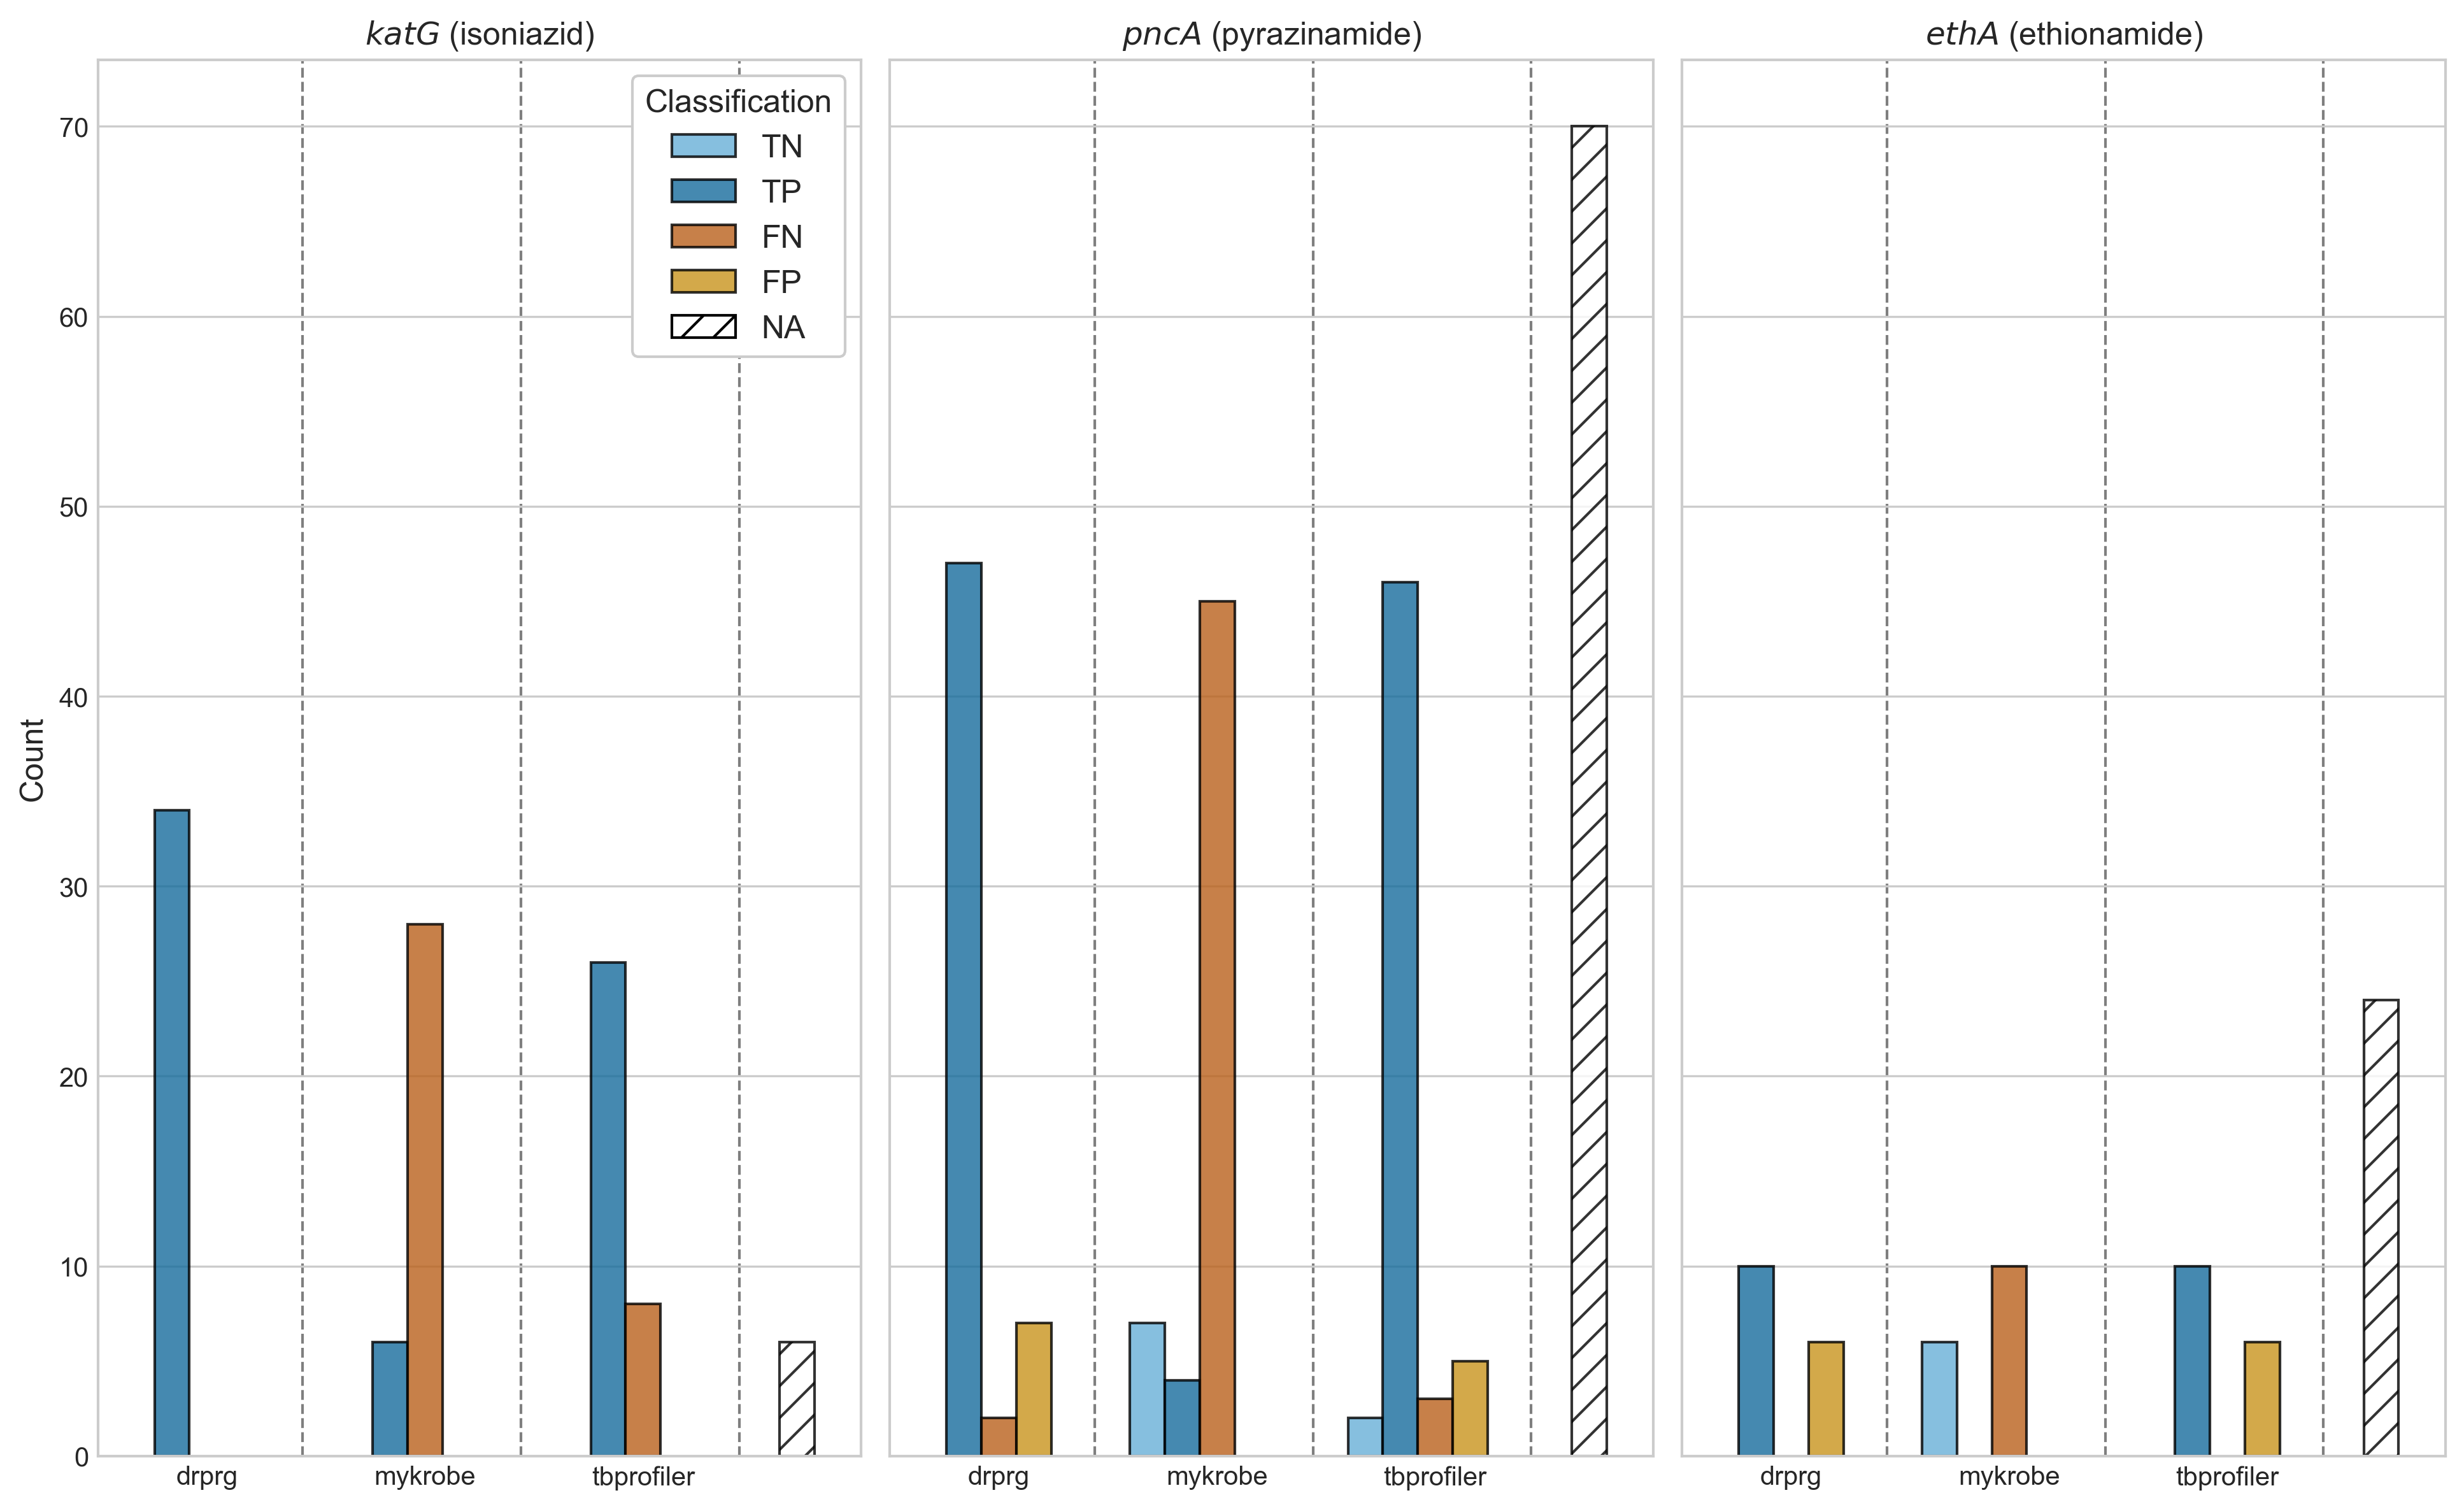

In [302]:
x = "tool"
y = "count"
hue = "classification"
col = "gene"
hatch = "//"
alpha = 0.8
hue_order = ["TN", "TP", "FN", "FP", "NA"]
fig, axes = plt.subplots(ncols=len(set(clf[col])), figsize=(13, 8), dpi=300, sharey=True, layout="tight")

for i, (ax, gene) in enumerate(zip(axes.flatten(), ["isoniazid", "pyrazinamide", "ethionamide"])):
    gene = d2g[gene]
    data = clf.query("gene==@gene")
    sns.barplot(
        data=data, x=x, y=y, hue=hue, 
        hue_order=hue_order, palette=colours, ax=ax, edgecolor="black", alpha=alpha, linewidth=1
    )
    ax.set_title(f"{gene} ({g2d[gene]})")
    ax.set_xlabel("")
    if i == 0:
        ax.set_ylabel("Count", fontsize=12)
    else:
        ax.set_ylabel("")

    if i != 0:
        ax.get_legend().remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        handles[-1] = mpatches.Patch(facecolor=colours[-1], hatch=hatch, label='NA', edgecolor="black")
        
        ax.legend(handles, labels, fontsize=12, title="Classification", title_fontsize=12, frameon=True, framealpha=1)
    
    na_val = data.query("classification == 'NA'")["count"].max()
    j = 0
    xmin, xmax = ax.get_xlim()

    gline = ax.get_ygridlines()[1]
    
    for bar in ax.patches:
        if bar.get_facecolor() == (1.0, 1.0, 1.0, alpha):
            xpos = bar.get_x() + 0.2

            ax.axvline(xpos, color="black", alpha=0.5, linewidth=gline.get_linewidth()*1.25, linestyle="--", zorder=-100)
            j += 1
            if j > 2:
                bar.set_hatch(hatch)
                bar.set_x(xmax * 1.05)
                bar.set_edgecolor("black")
            else:
                bar.set_alpha(0)
    ax.set_xlim((xmin, xmax * 1.2))

# fig.savefig("../../docs/paper/figures/gene_absense.png")

In [287]:
help(ax.legend)


Help on method legend in module matplotlib.axes._axes:

legend(*args, **kwargs) method of matplotlib.axes._axes.Axes instance
    Place a legend on the Axes.
    
    Call signatures::
    
        legend()
        legend(handles, labels)
        legend(handles=handles)
        legend(labels)
    
    The call signatures correspond to the following different ways to use
    this method:
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()
    
    .. note::
        Specifi

In [246]:
help(ax.vlines)

Help on method vlines in module matplotlib.axes._axes:

vlines(x, ymin, ymax, colors=None, linestyles='solid', label='', *, data=None, **kwargs) method of matplotlib.axes._axes.Axes instance
    Plot vertical lines at each *x* from *ymin* to *ymax*.
    
    Parameters
    ----------
    x : float or array-like
        x-indexes where to plot the lines.
    
    ymin, ymax : float or array-like
        Respective beginning and end of each line. If scalars are
        provided, all lines will have the same length.
    
    colors : list of colors, default: :rc:`lines.color`
    
    linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}, optional
    
    label : str, default: ''
    
    Returns
    -------
    `~matplotlib.collections.LineCollection`
    
    Other Parameters
    ----------------
    data : indexable object, optional
        If given, the following parameters also accept a string ``s``, which is
        interpreted as ``data[s]`` (unless this raises an exception):
    

In [228]:
help(bar.set_hatch)

Help on method set_hatch in module matplotlib.patches:

set_hatch(hatch) method of matplotlib.patches.Rectangle instance
    Set the hatching pattern.
    
    *hatch* can be one of::
    
      /   - diagonal hatching
      \   - back diagonal
      |   - vertical
      -   - horizontal
      +   - crossed
      x   - crossed diagonal
      o   - small circle
      O   - large circle
      .   - dots
      *   - stars
    
    Letters can be combined, in which case all the specified
    hatchings are done.  If same letter repeats, it increases the
    density of hatching of that pattern.
    
    Hatching is supported in the PostScript, PDF, SVG and Agg
    backends only.
    
    Parameters
    ----------
    hatch : {'/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}



In [59]:
ax.get_xlim()

(-0.5, 2.5)

In [54]:
data.query("classification == 'NA'")["count"].max()

67

In [48]:
bar.get_height()

67.0

In [10]:
dir(bar)

['_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_antialiased',
 '_aspect_ratio_correction',
 '_axes',
 '_callbacks',
 '_capstyle',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_convert_units',
 '_convert_xy_units',
 '_dash_pattern',
 '_default_contains',
 '_draw_paths_with_artist_properties',
 '_edge_default',
 '_edgecolor',
 '_facecolor',
 '_fill',
 '_fully_clipped_to_axes',
 '_gid',
 '_hatch',
 '_hatch_color',
 '_height',
 '_in_layout',
 '_internal_update',
 '_joinstyle',
 '_label',
 '_linestyle',
 '_linewidth',
 '_mouseover',
 '_original_edgecolor',
 '_original_fac

In [180]:
help(plt.subplots)

Help on function subplots in module matplotlib.pyplot:

subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, width_ratios=None, height_ratios=None, subplot_kw=None, gridspec_kw=None, **fig_kw)
    Create a figure and a set of subplots.
    
    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.
    
    Parameters
    ----------
    nrows, ncols : int, default: 1
        Number of rows/columns of the subplot grid.
    
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:
    
        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.
    
        When subplots 

In [137]:
type(g)

seaborn.axisgrid.FacetGrid